In [1]:
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array
from numpy import mean
from numpy import cov
from PIL import Image
from matplotlib.pyplot import *
import os
import  random
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from scipy.stats import norm
import PIL
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import itertools
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [2]:
data_dir = pathlib.Path("./train")
image_count1 = len(list(data_dir.glob("*/*.jpg")))
#image_count2 = len(list(data_dir.glob("*/*.png")))
#image_count2 = len(list(data_dir.glob("*/*.jp")))
print(image_count1)

6000


In [3]:
validation_rate = 0.2
batch_size = 128
img_height = 256
img_width = 256

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=validation_rate,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6000 files belonging to 12 classes.
Using 4800 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=validation_rate,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6000 files belonging to 12 classes.
Using 1200 files for validation.


In [6]:
train_labels =  np.array([])
for x, y in train_ds:
    train_labels = np.concatenate([train_labels, y.numpy()])
print(train_labels.shape)

(4800,)


In [7]:
test_labels =  np.array([])
for x, y in val_ds:
    test_labels = np.concatenate([test_labels, y.numpy()])
print(test_labels.shape)

(1200,)


In [8]:
class_names = train_ds.class_names
print(class_names)

['dog', 'dragon', 'goat', 'horse', 'monkey', 'ox', 'pig', 'rabbit', 'rat', 'rooster', 'snake', 'tiger']


In [9]:
val_class_names = val_ds.class_names
print(val_class_names)

['dog', 'dragon', 'goat', 'horse', 'monkey', 'ox', 'pig', 'rabbit', 'rat', 'rooster', 'snake', 'tiger']


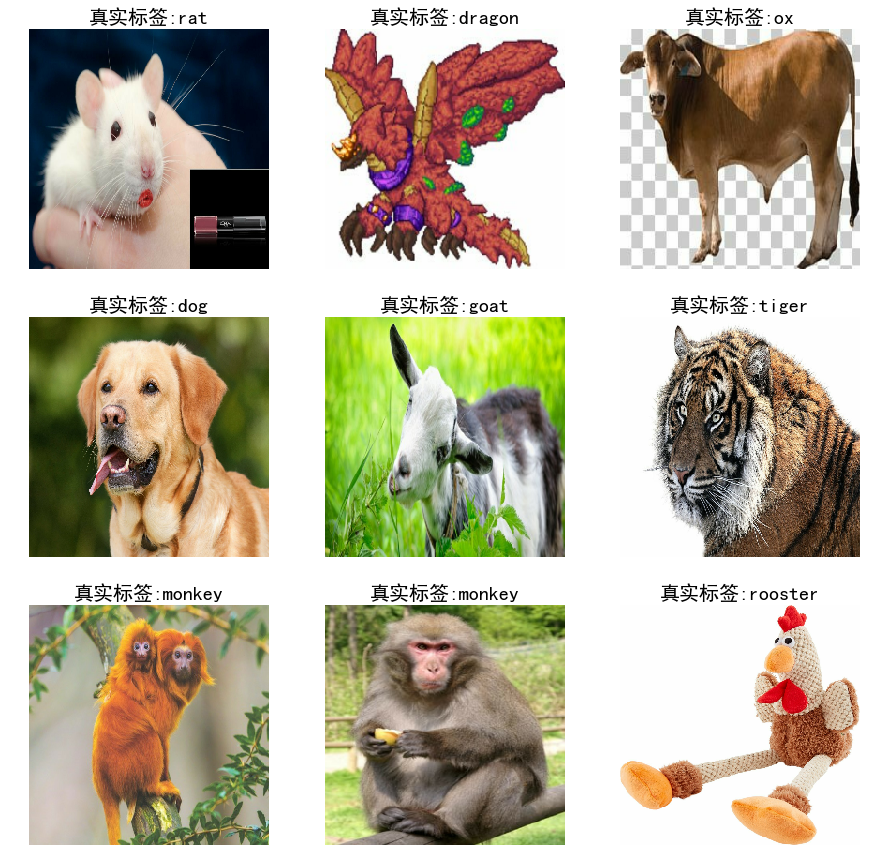

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('真实标签:{}'.format(class_names[labels[i]]),fontsize=20)
        plt.axis("off")

In [12]:
test_sample = batch_size

In [13]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
num_classes = 12

model = tf.keras.models.Sequential([
  layers.experimental.preprocessing.Resizing(height=256, width=256, input_shape=(img_height, img_width, 3)),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(2048, activation='relu'),
  layers.Dense(num_classes)
])

In [17]:
model.layers

In [18]:
model.layers[0].output

<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'resizing')>

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        1

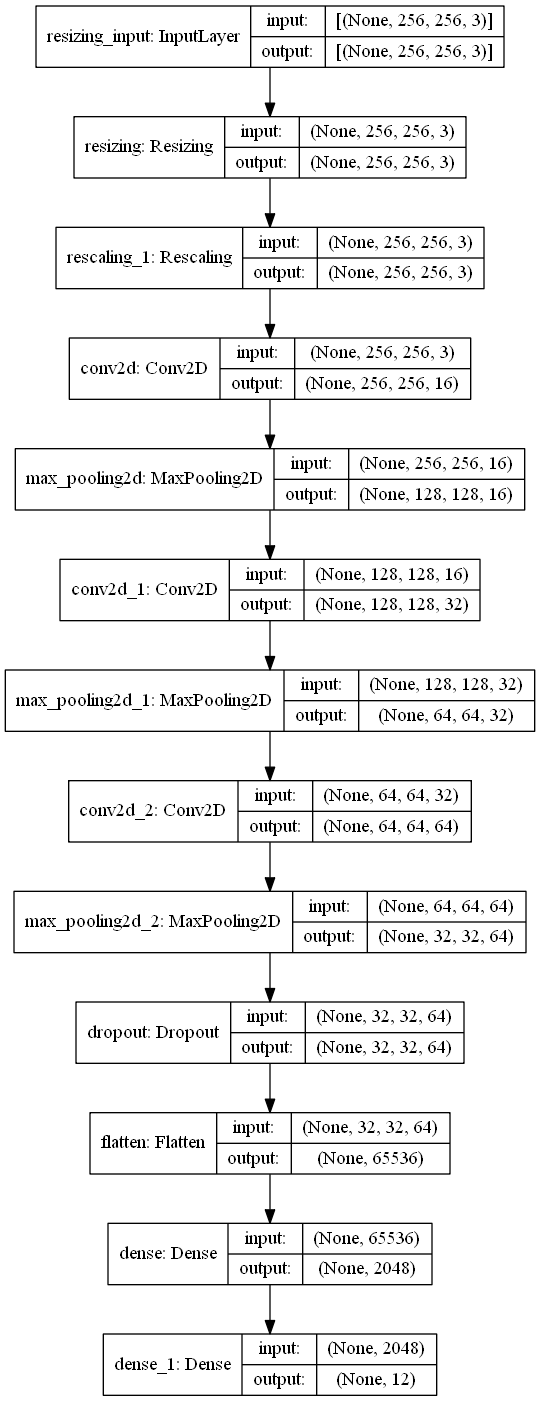

In [28]:
tf.keras.utils.plot_model(model, to_file='CNN_Architecture.png', show_shapes=True, show_layer_names=True)

In [21]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
 
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('accuracy'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_accuracy'))
 
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('accuracy'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_accuracy'))
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure(figsize=(4, 4), dpi=100)
        #my_x_ticks = np.arange(0, 3, 1)
        #my_y_ticks = np.arange(0, 1, 0.1)
        #plt.yticks(my_y_ticks)
        #plt.xticks(my_x_ticks)
        
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right") 
        plt.show()

Epoch 1/20
38/38 [==============================] - 314s 8s/step - loss: 7.1093 - accuracy: 0.0902 - val_loss: 2.3519 - val_accuracy: 0.1625
Epoch 2/20
38/38 [==============================] - 274s 7s/step - loss: 2.2505 - accuracy: 0.2199 - val_loss: 2.2115 - val_accuracy: 0.2625
Epoch 3/20
38/38 [==============================] - 331s 9s/step - loss: 1.9489 - accuracy: 0.3581 - val_loss: 2.0127 - val_accuracy: 0.3392
Epoch 4/20
38/38 [==============================] - 329s 9s/step - loss: 1.6703 - accuracy: 0.4528 - val_loss: 2.0321 - val_accuracy: 0.3433
Epoch 5/20
38/38 [==============================] - 297s 8s/step - loss: 1.3529 - accuracy: 0.5617 - val_loss: 2.0616 - val_accuracy: 0.3550
Epoch 6/20
38/38 [==============================] - 283s 7s/step - loss: 0.9234 - accuracy: 0.7156 - val_loss: 2.2896 - val_accuracy: 0.3683
Epoch 7/20
38/38 [==============================] - 279s 7s/step - loss: 0.6006 - accuracy: 0.8129 - val_loss: 2.7010 - val_accuracy: 0.3492
Epoch 8/20
38

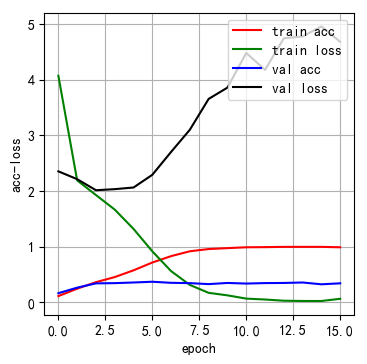

In [22]:
history = LossHistory()
earlyStopCb = EarlyStopping(monitor='val_accuracy', restore_best_weights=False, patience=10)
cnn_history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20,
  callbacks=[history, earlyStopCb])
history.loss_plot('epoch')

(1, 256, 256, 3)
resizing_input (1, 256, 256, 3) 


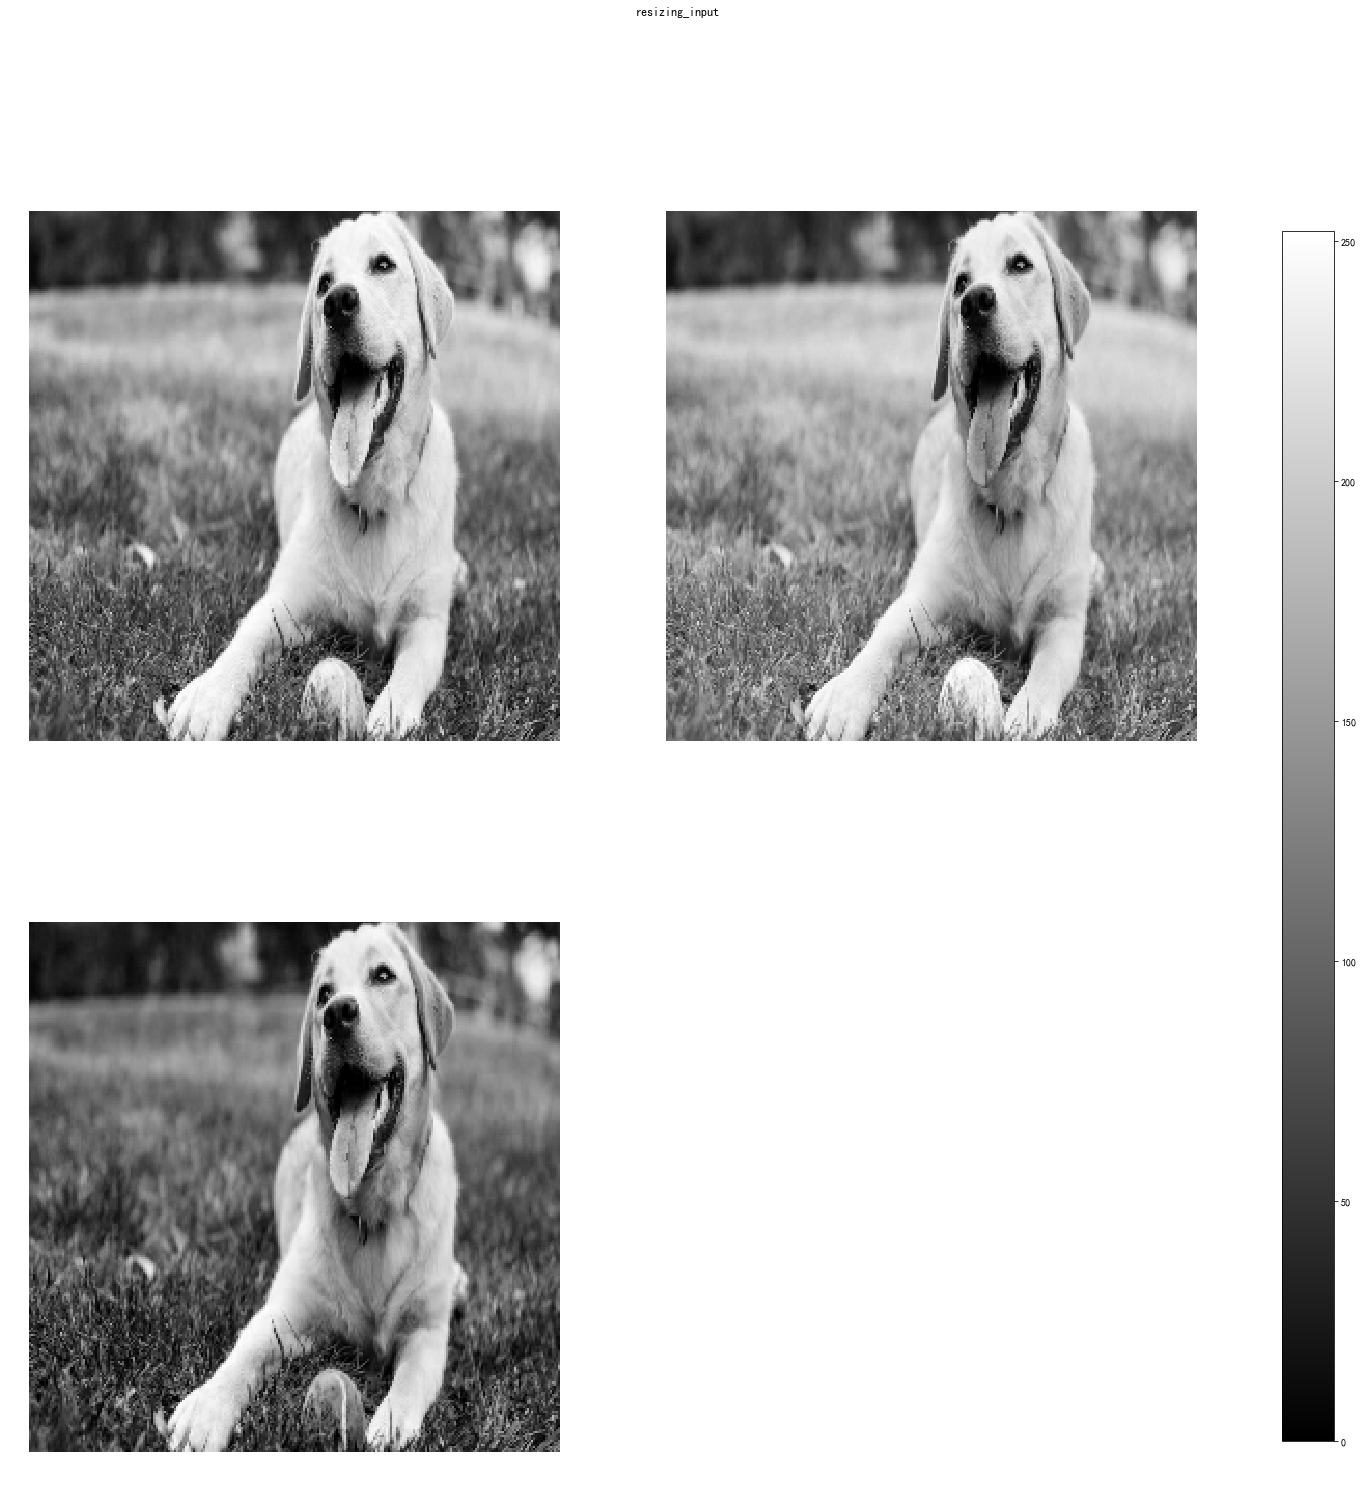

resizing (1, 256, 256, 3) 


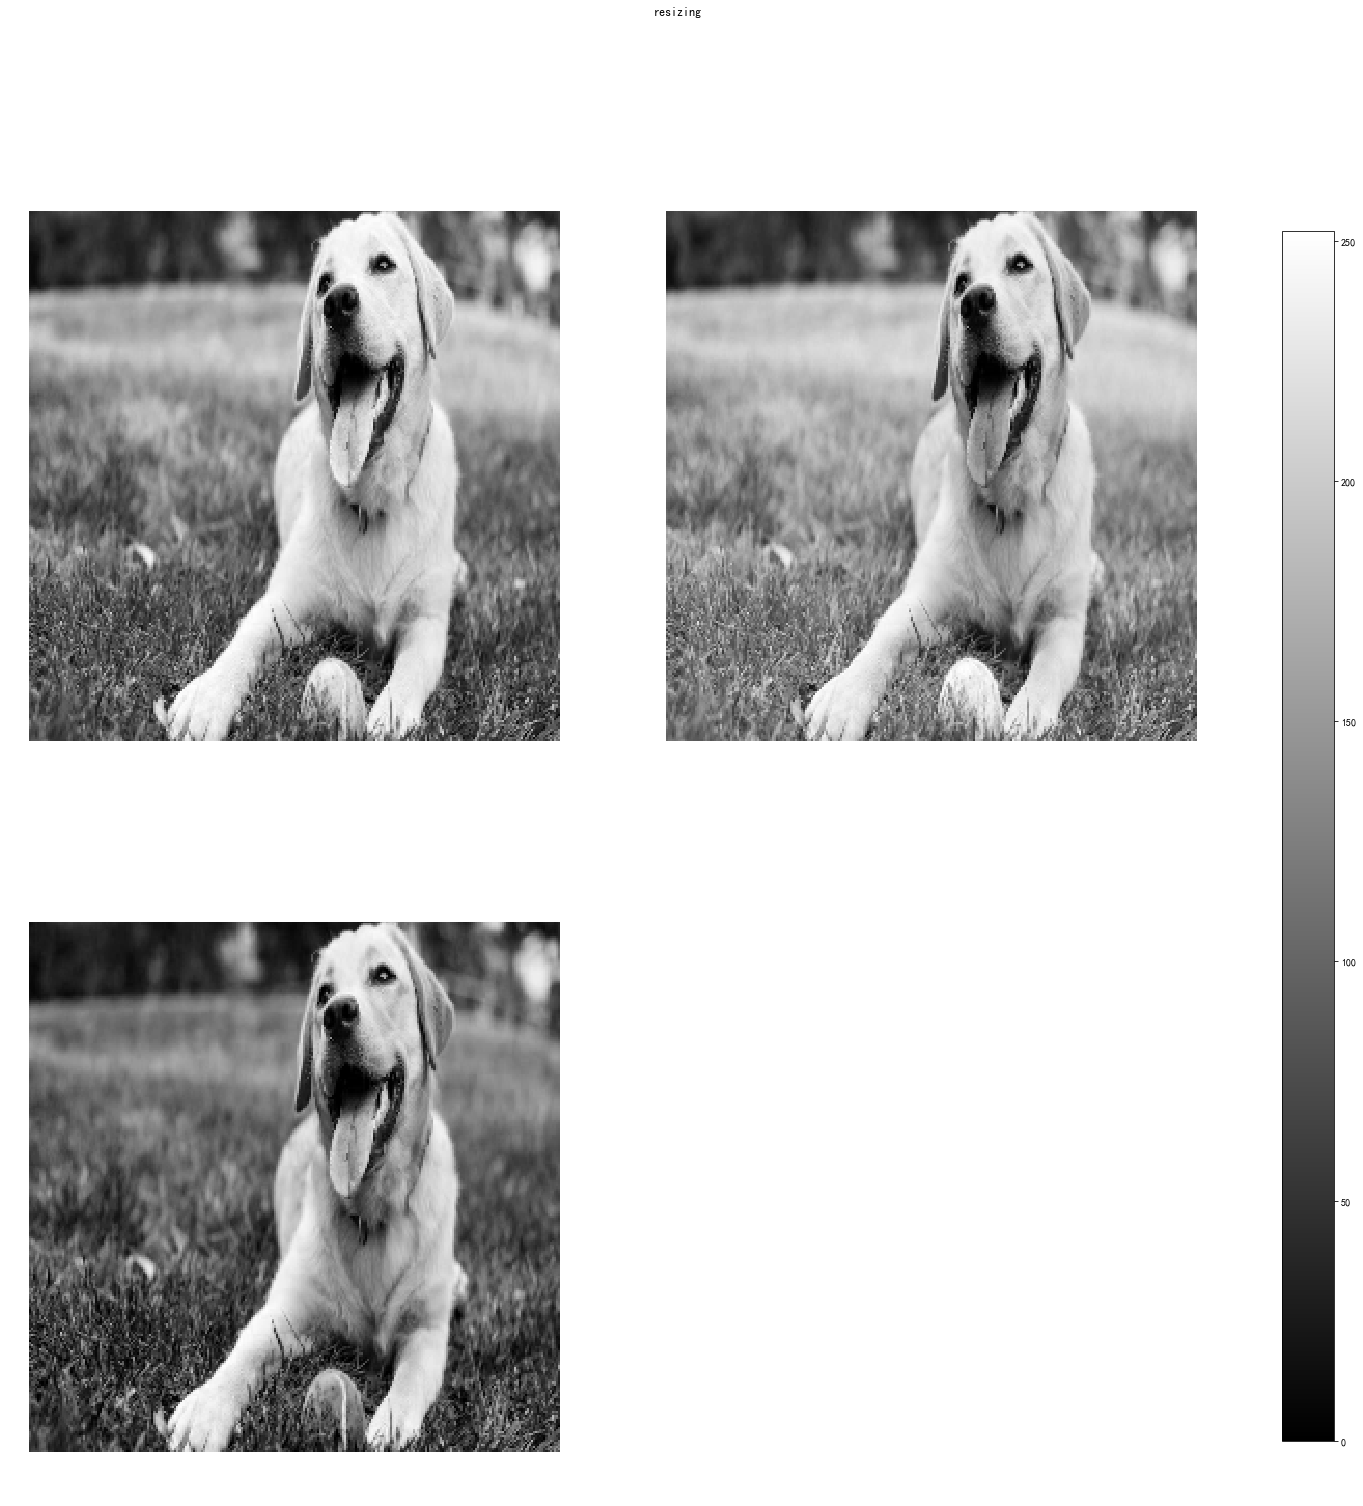

rescaling_1 (1, 256, 256, 3) 


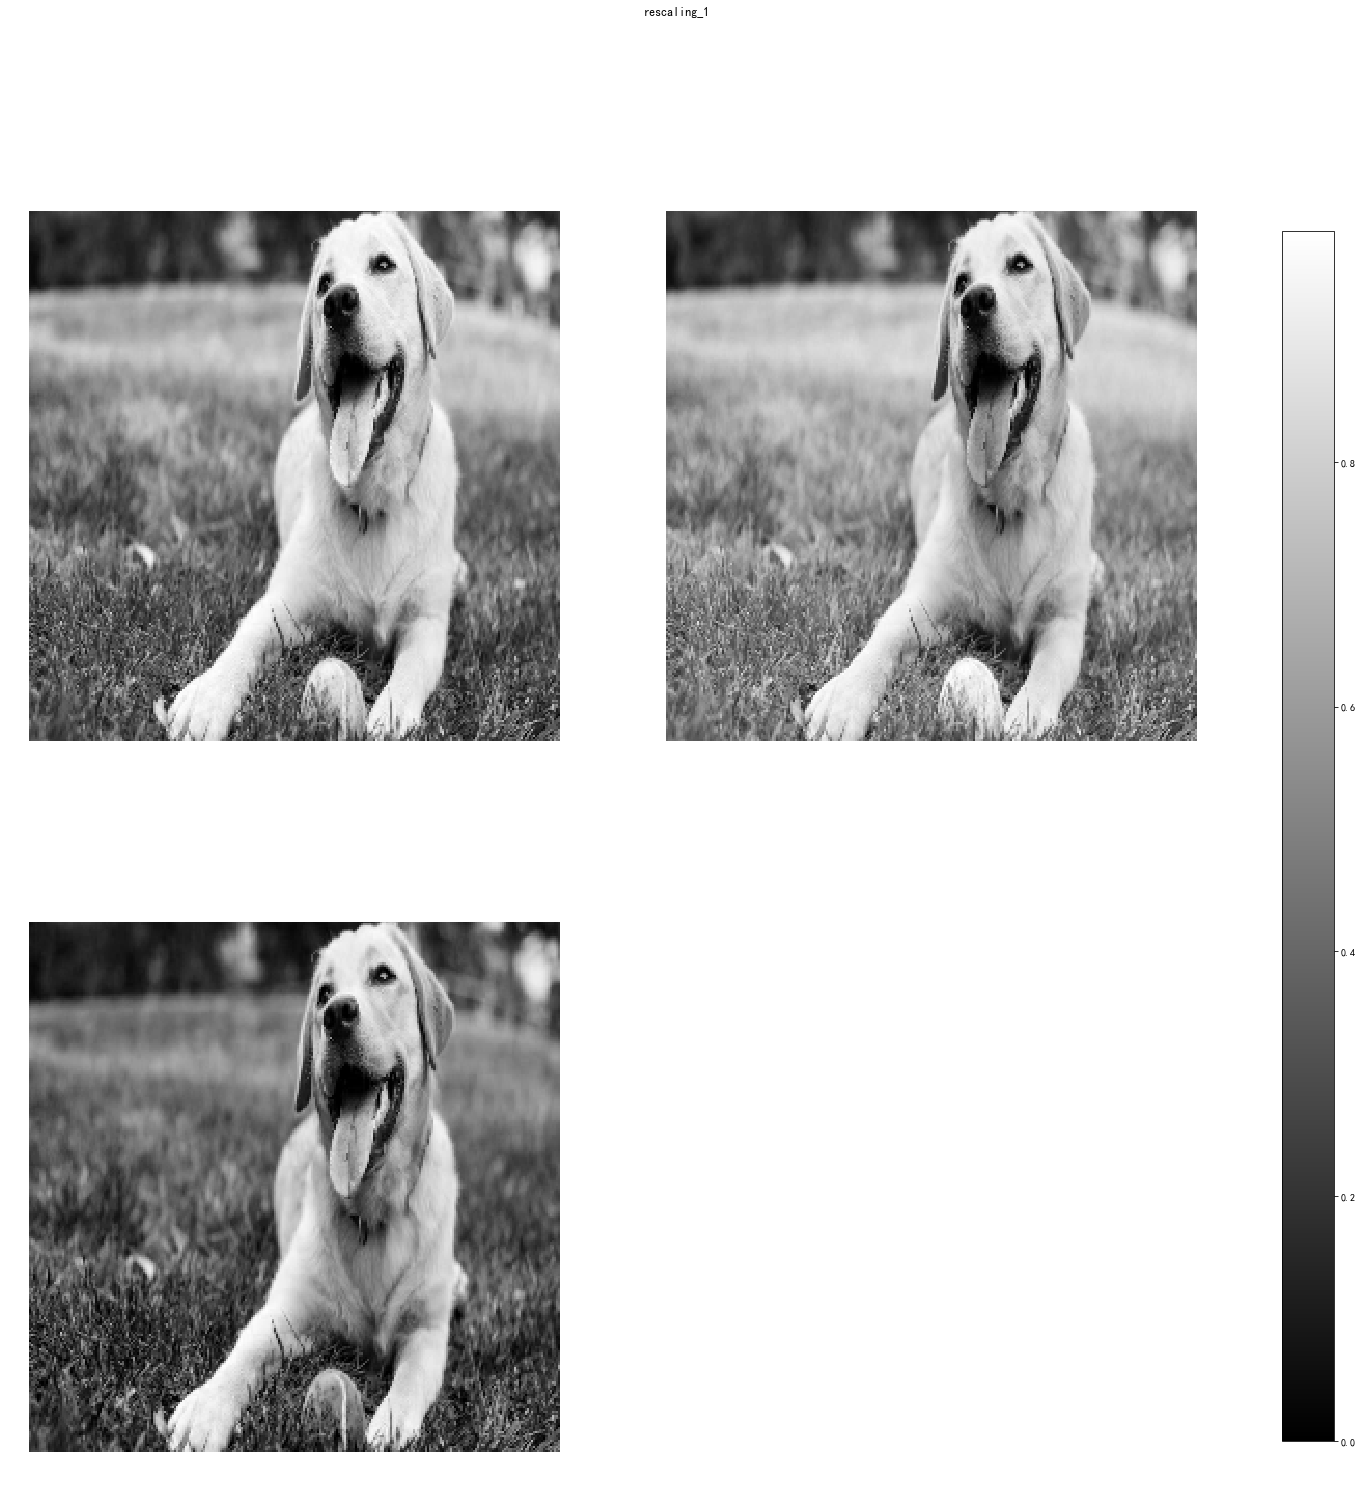

conv2d (1, 256, 256, 16) 


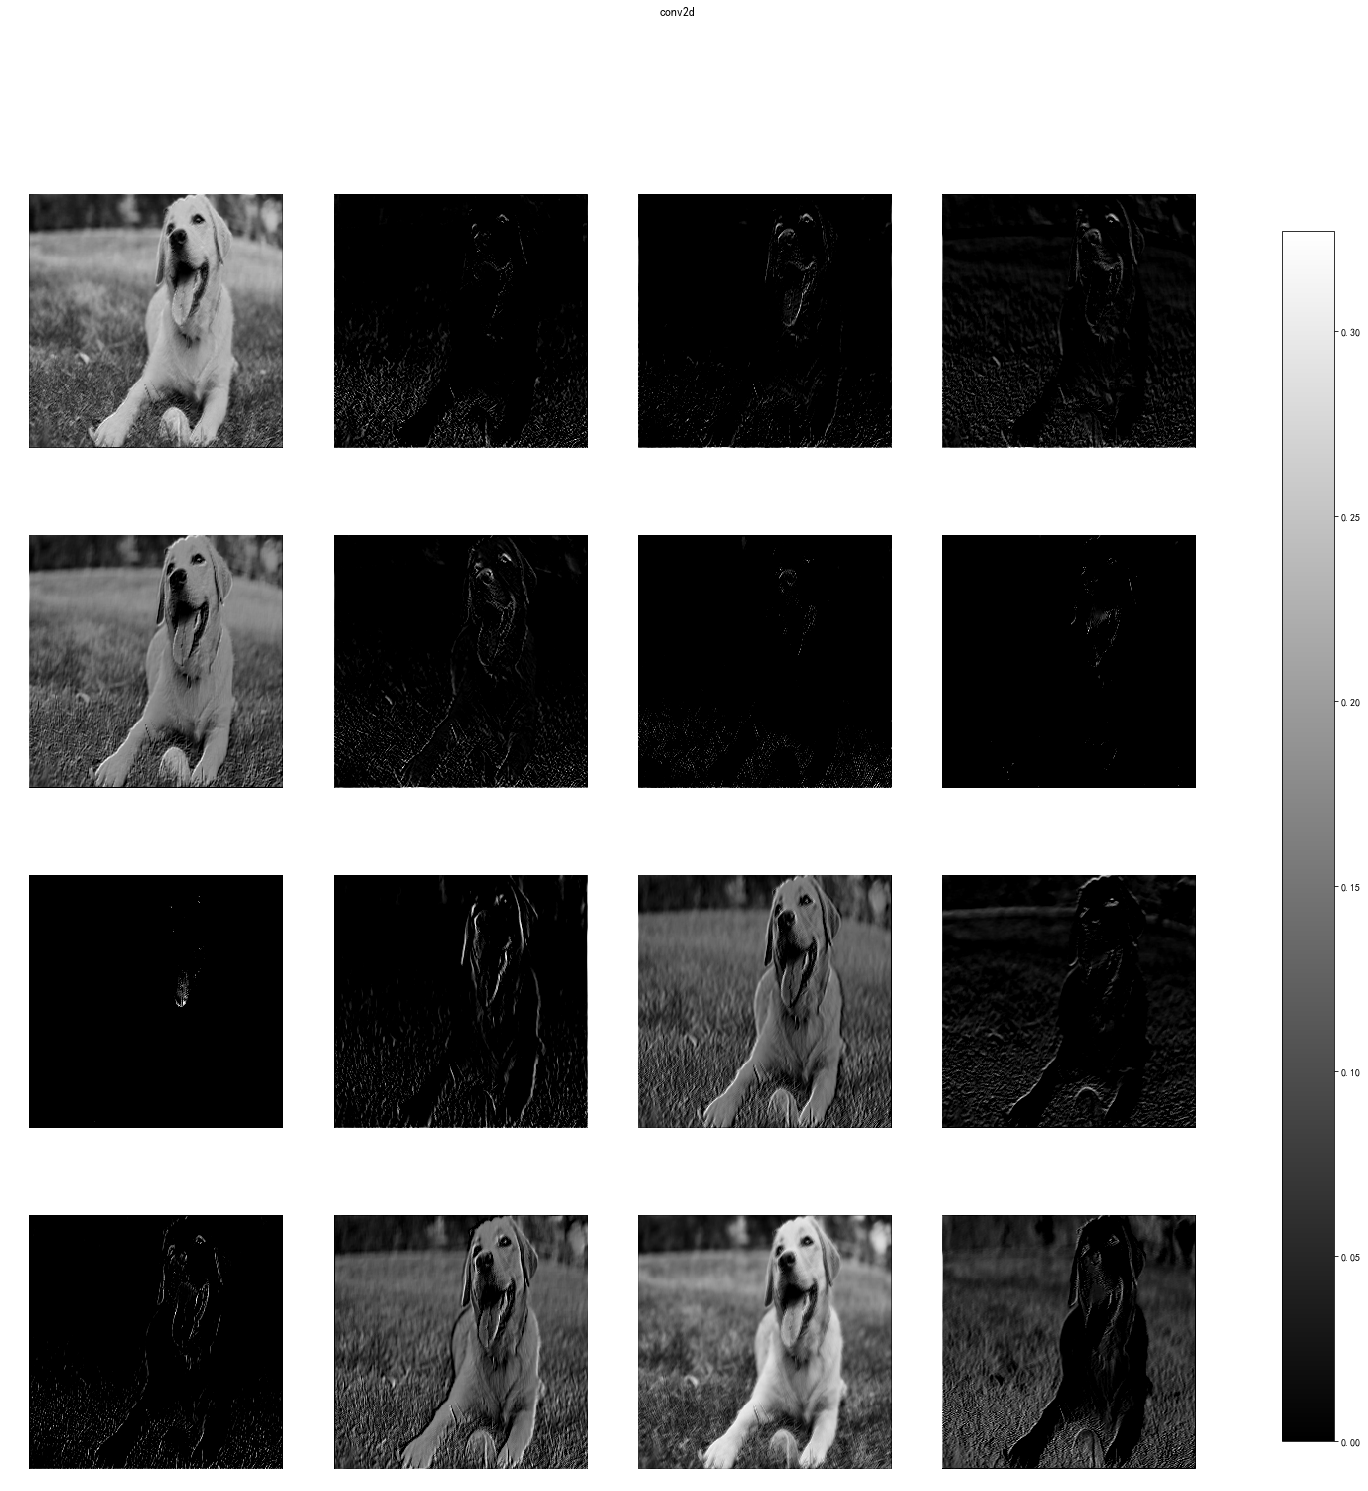

max_pooling2d (1, 128, 128, 16) 


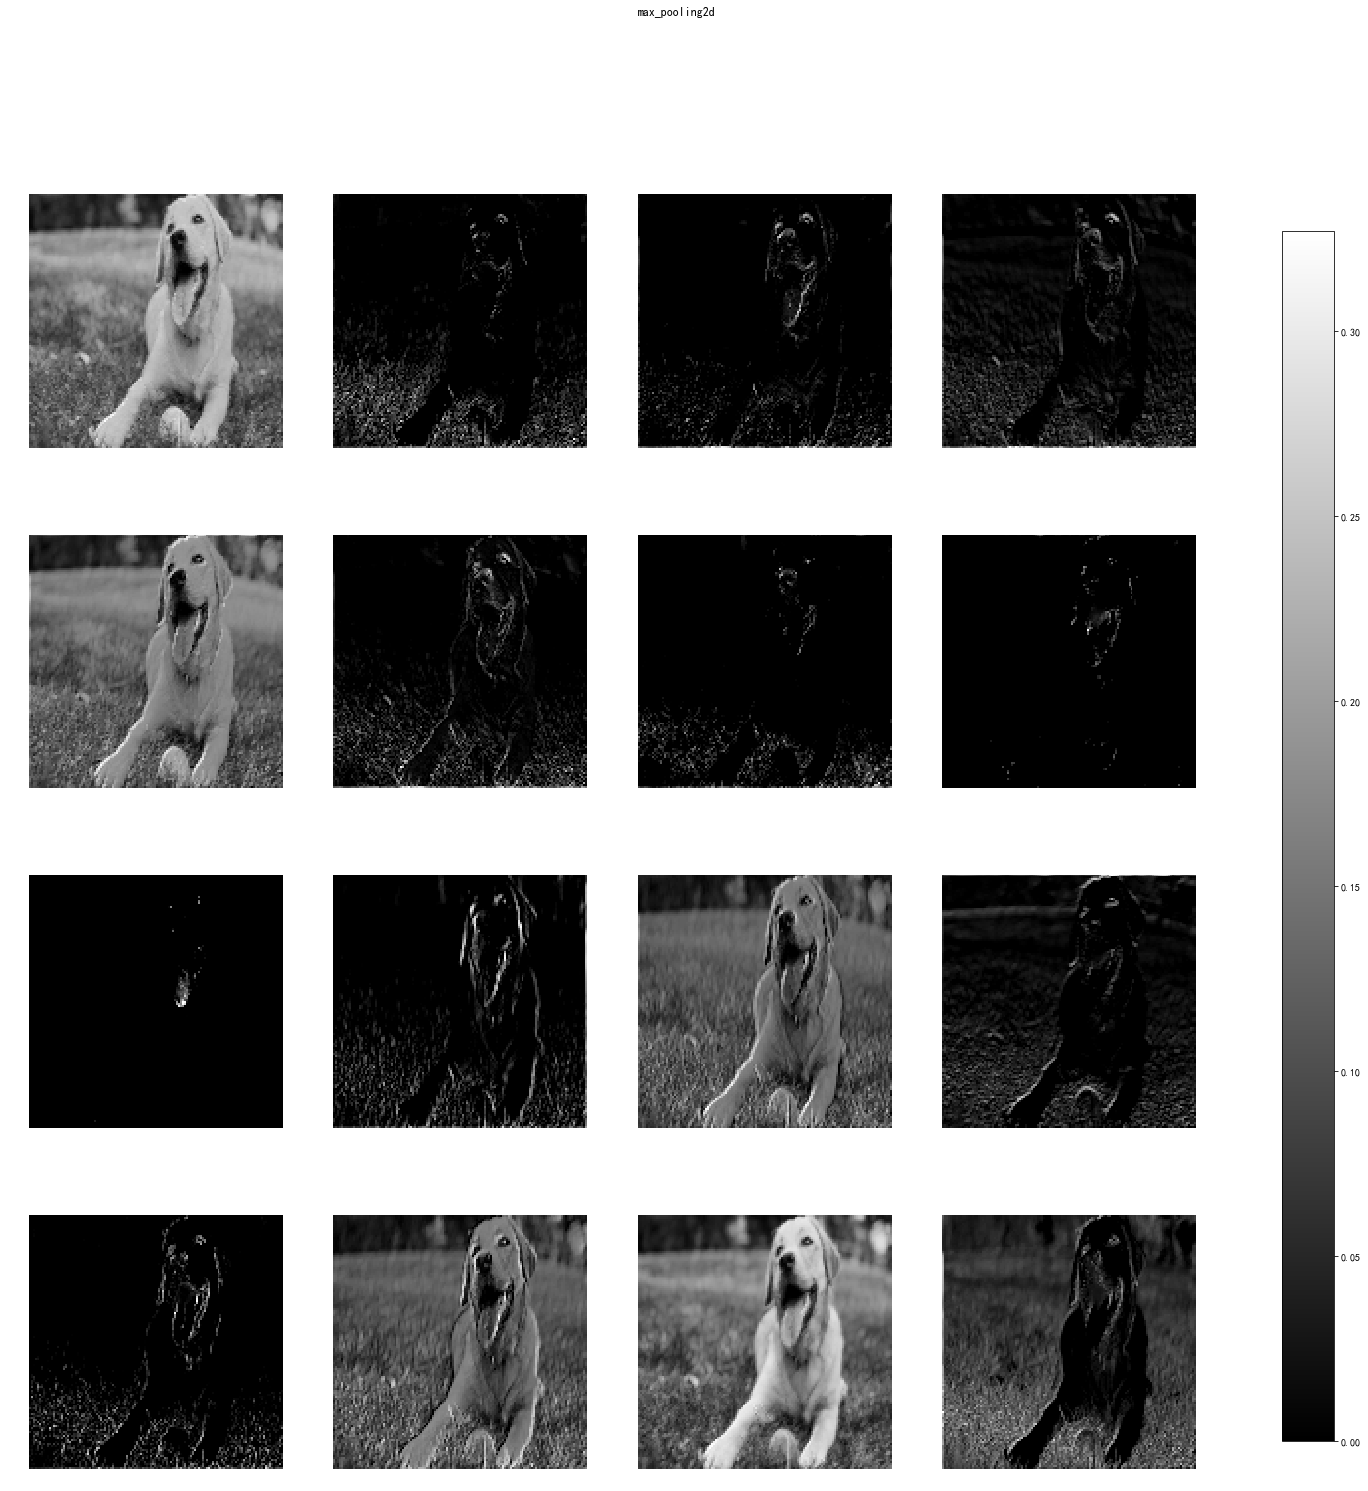

conv2d_1 (1, 128, 128, 32) 


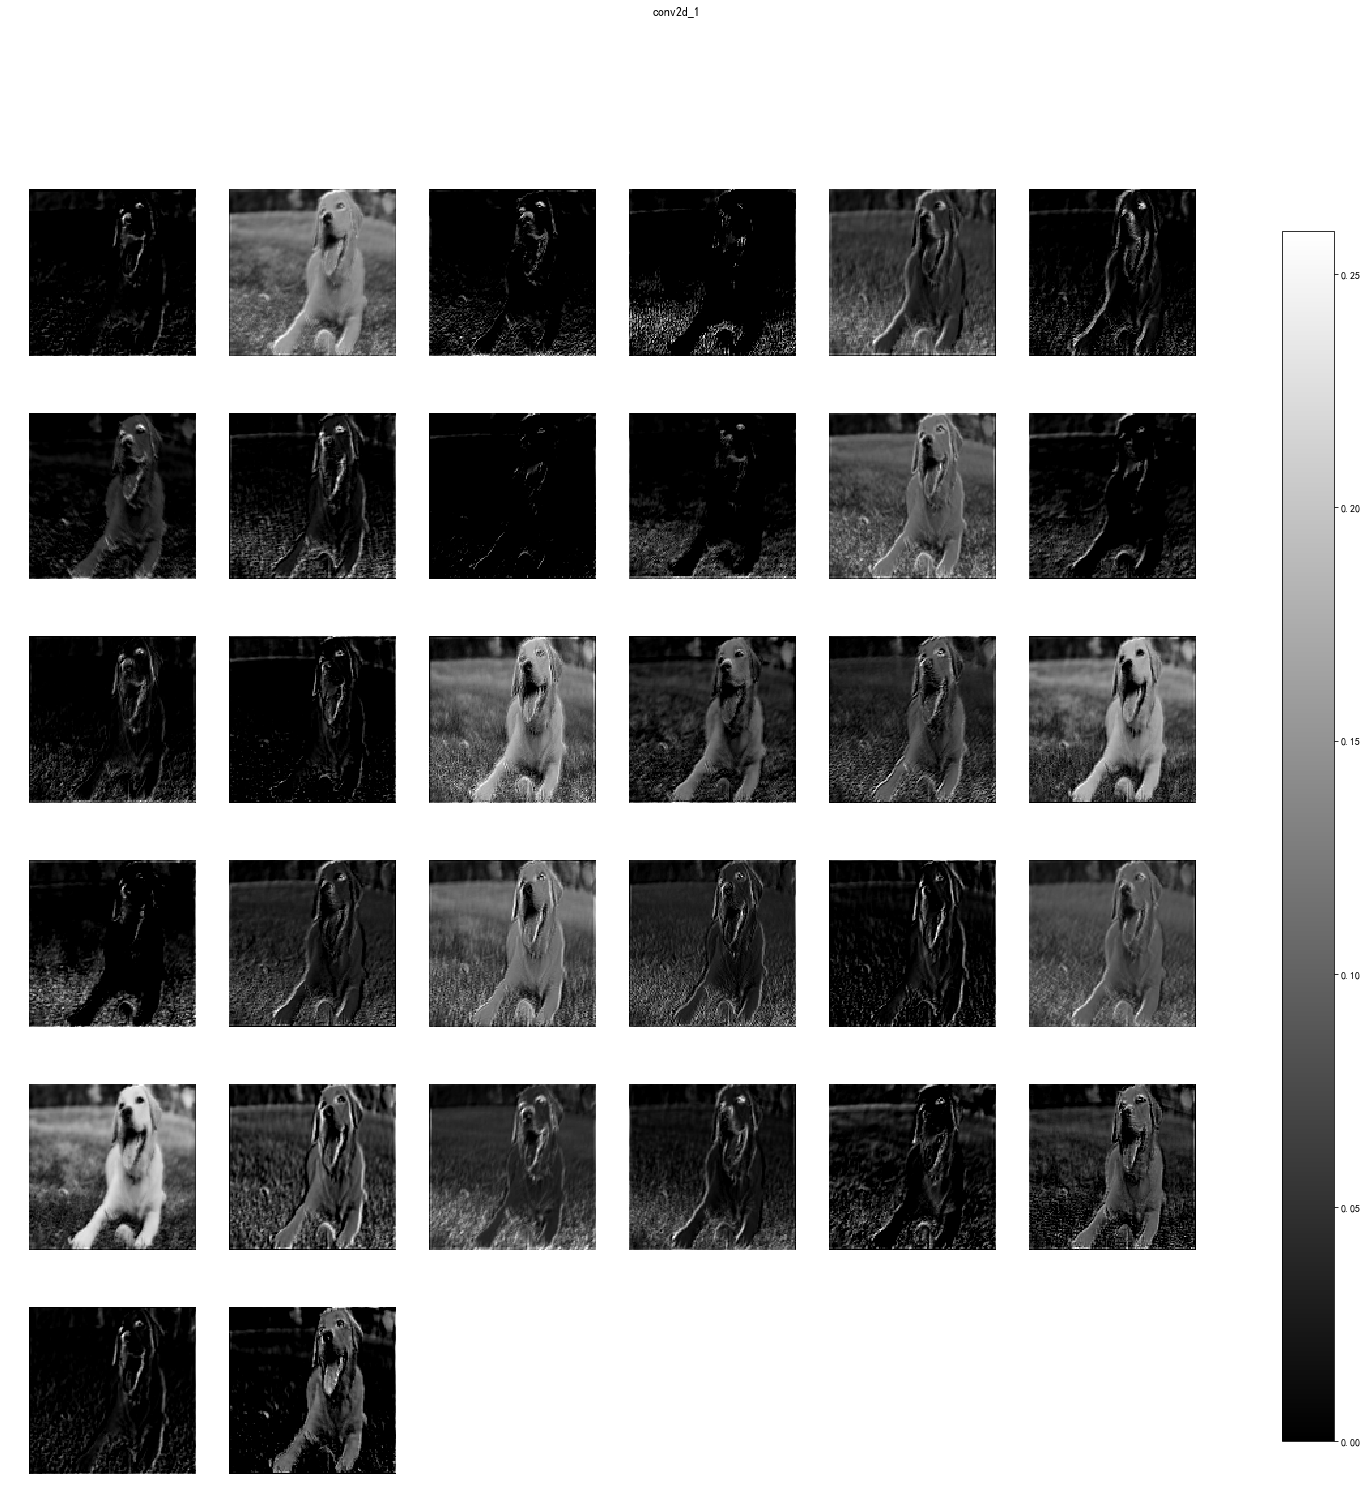

max_pooling2d_1 (1, 64, 64, 32) 


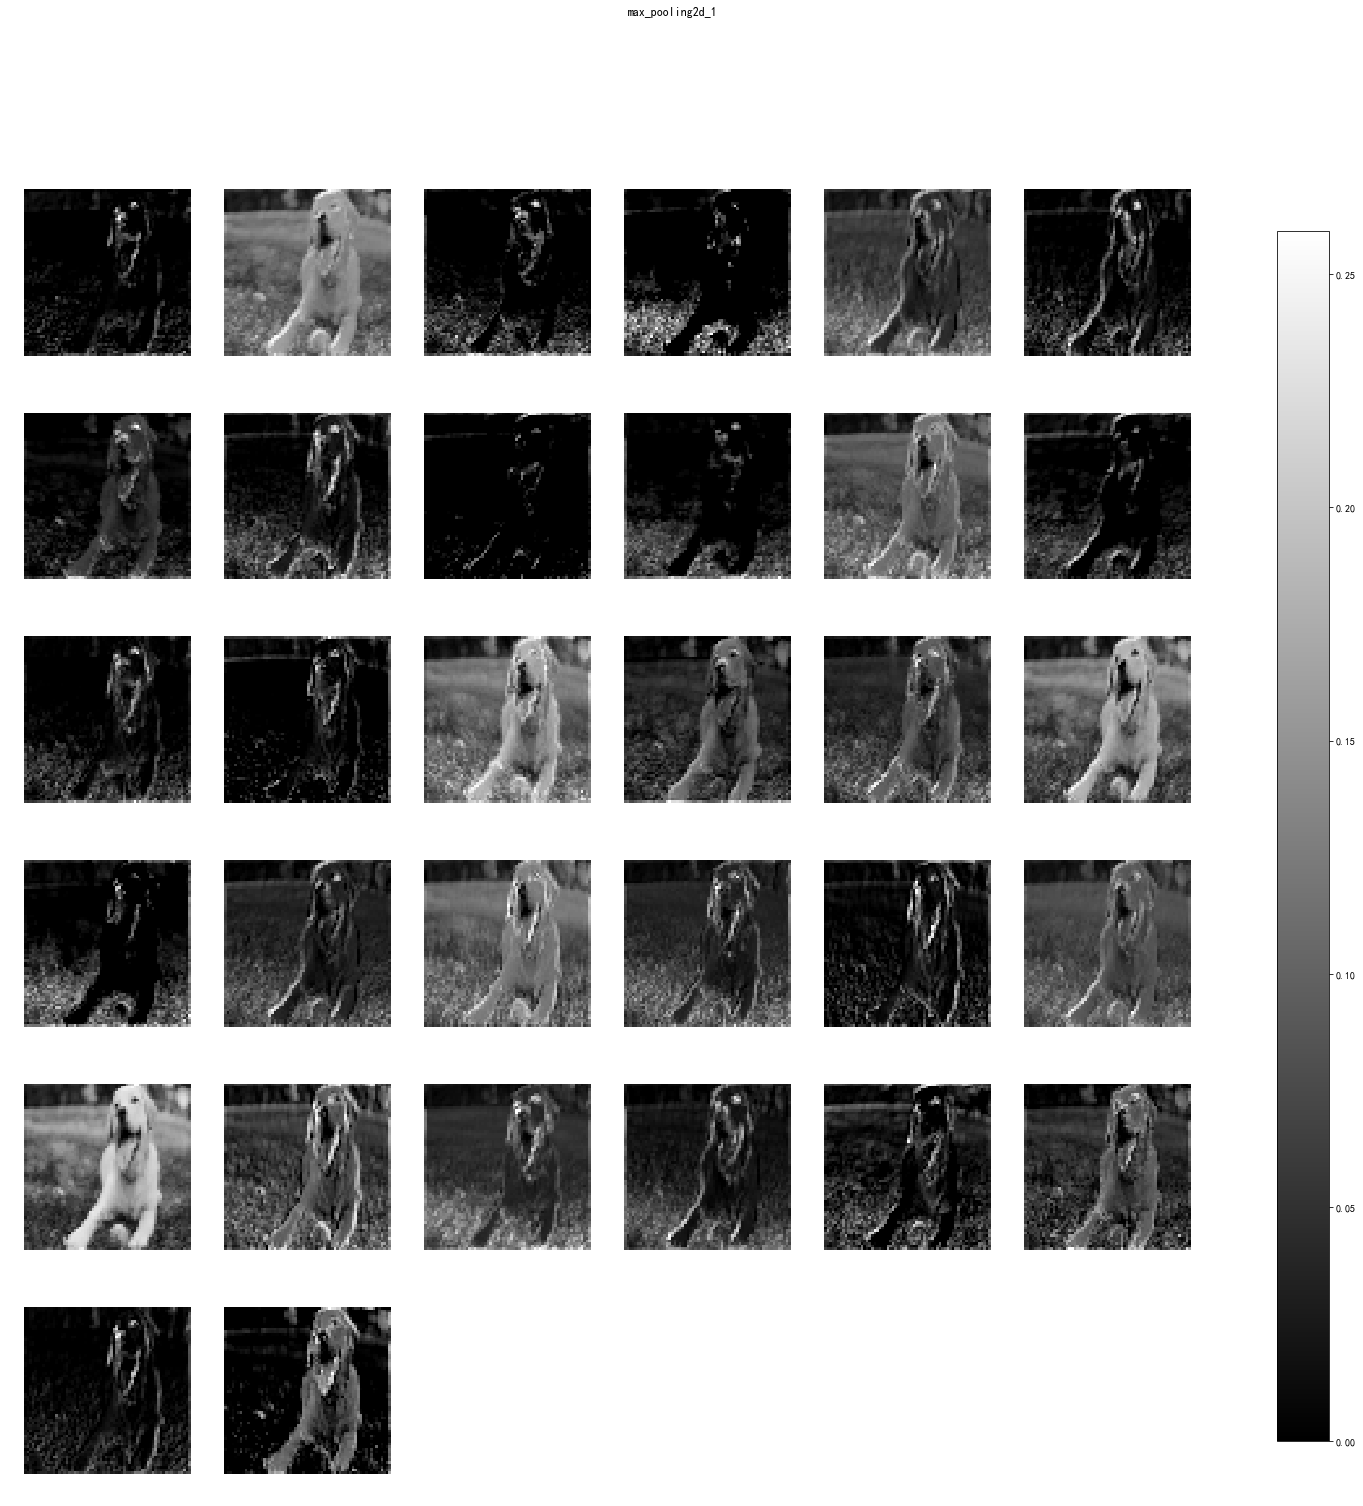

conv2d_2 (1, 64, 64, 64) 


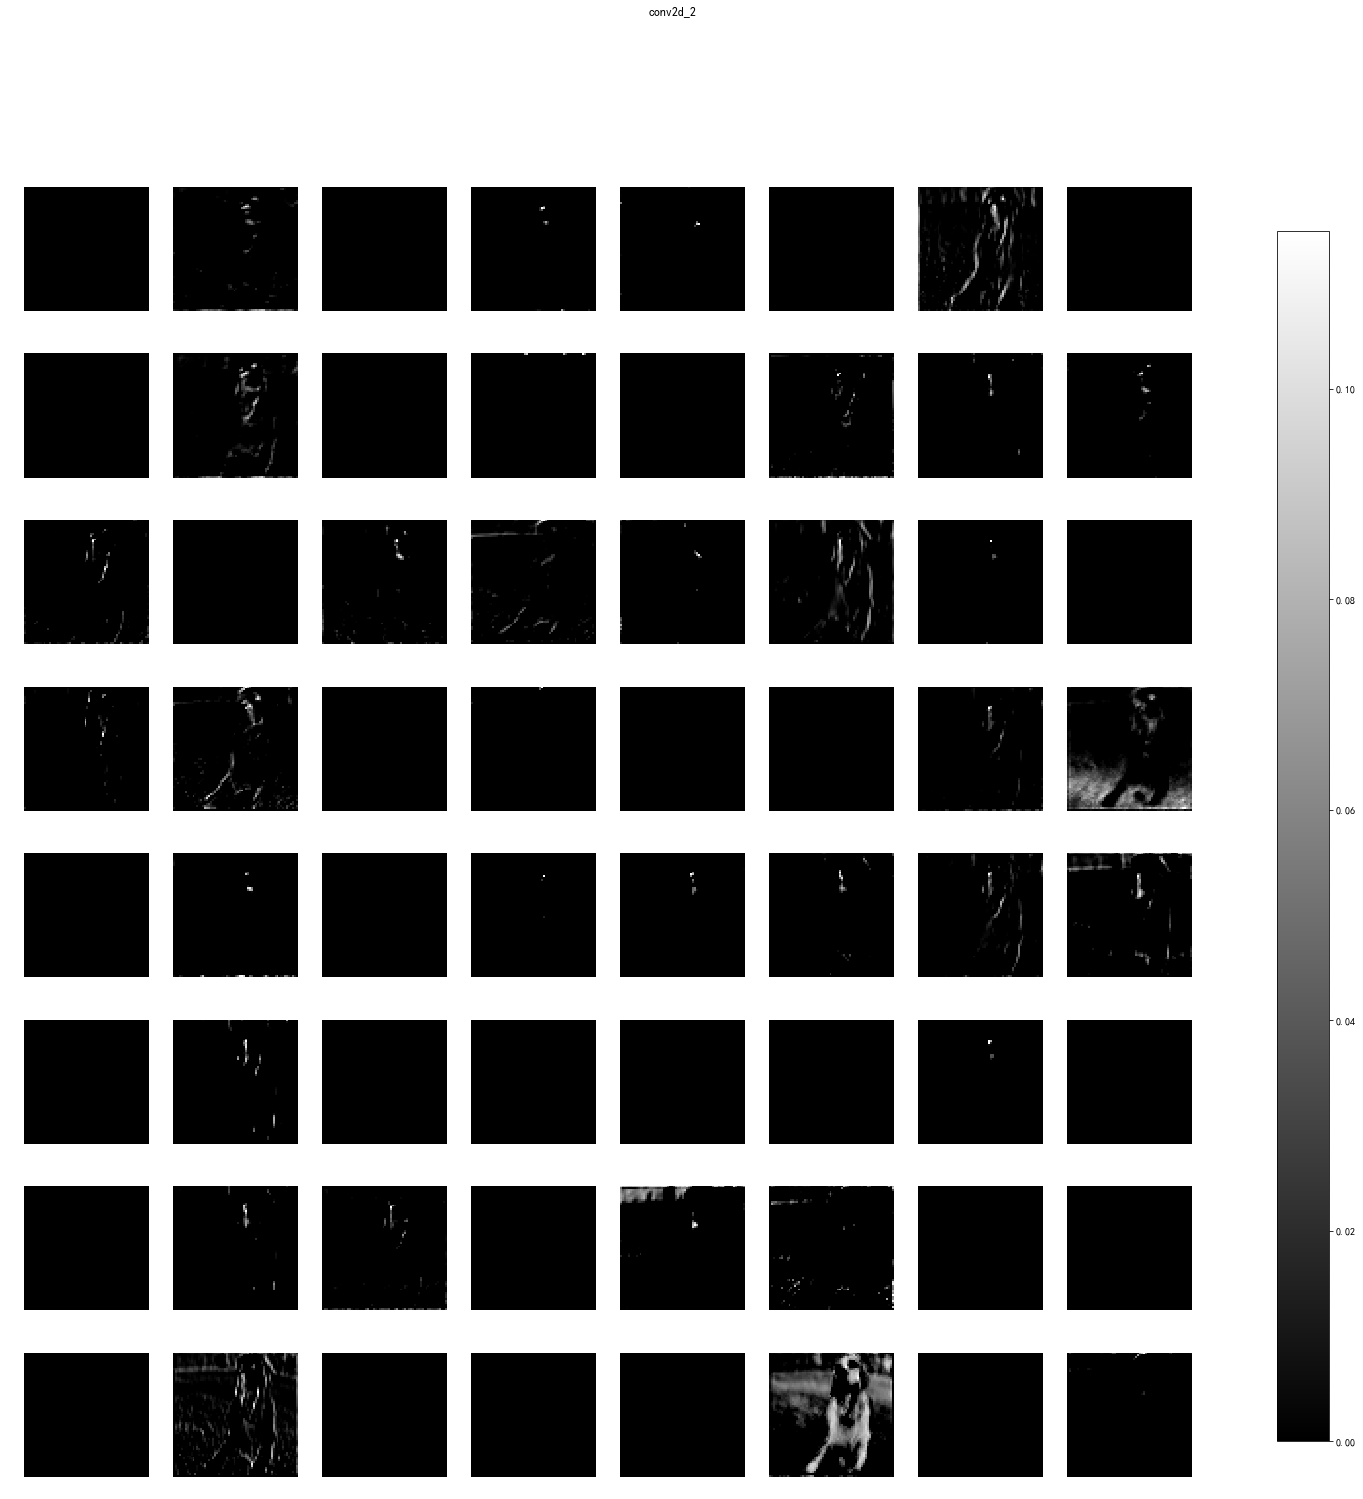

max_pooling2d_2 (1, 32, 32, 64) 


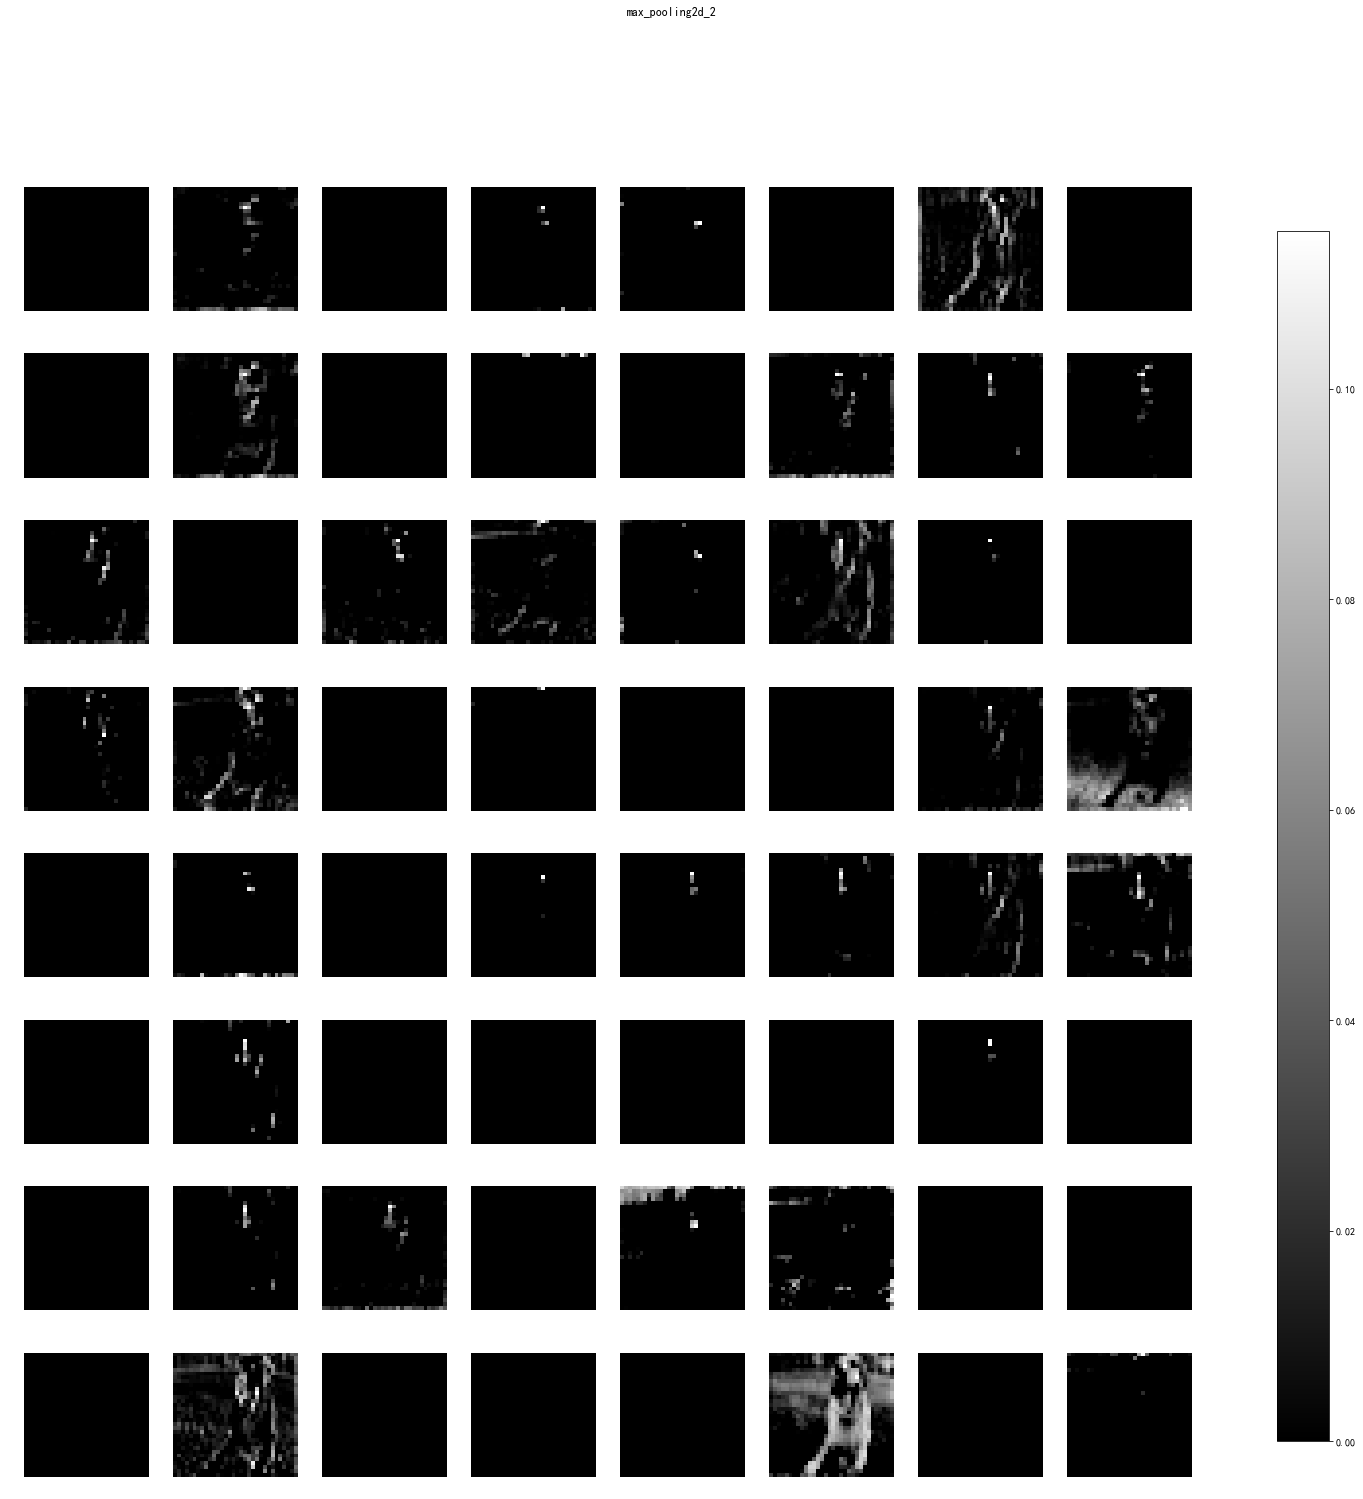

dropout (1, 32, 32, 64) 


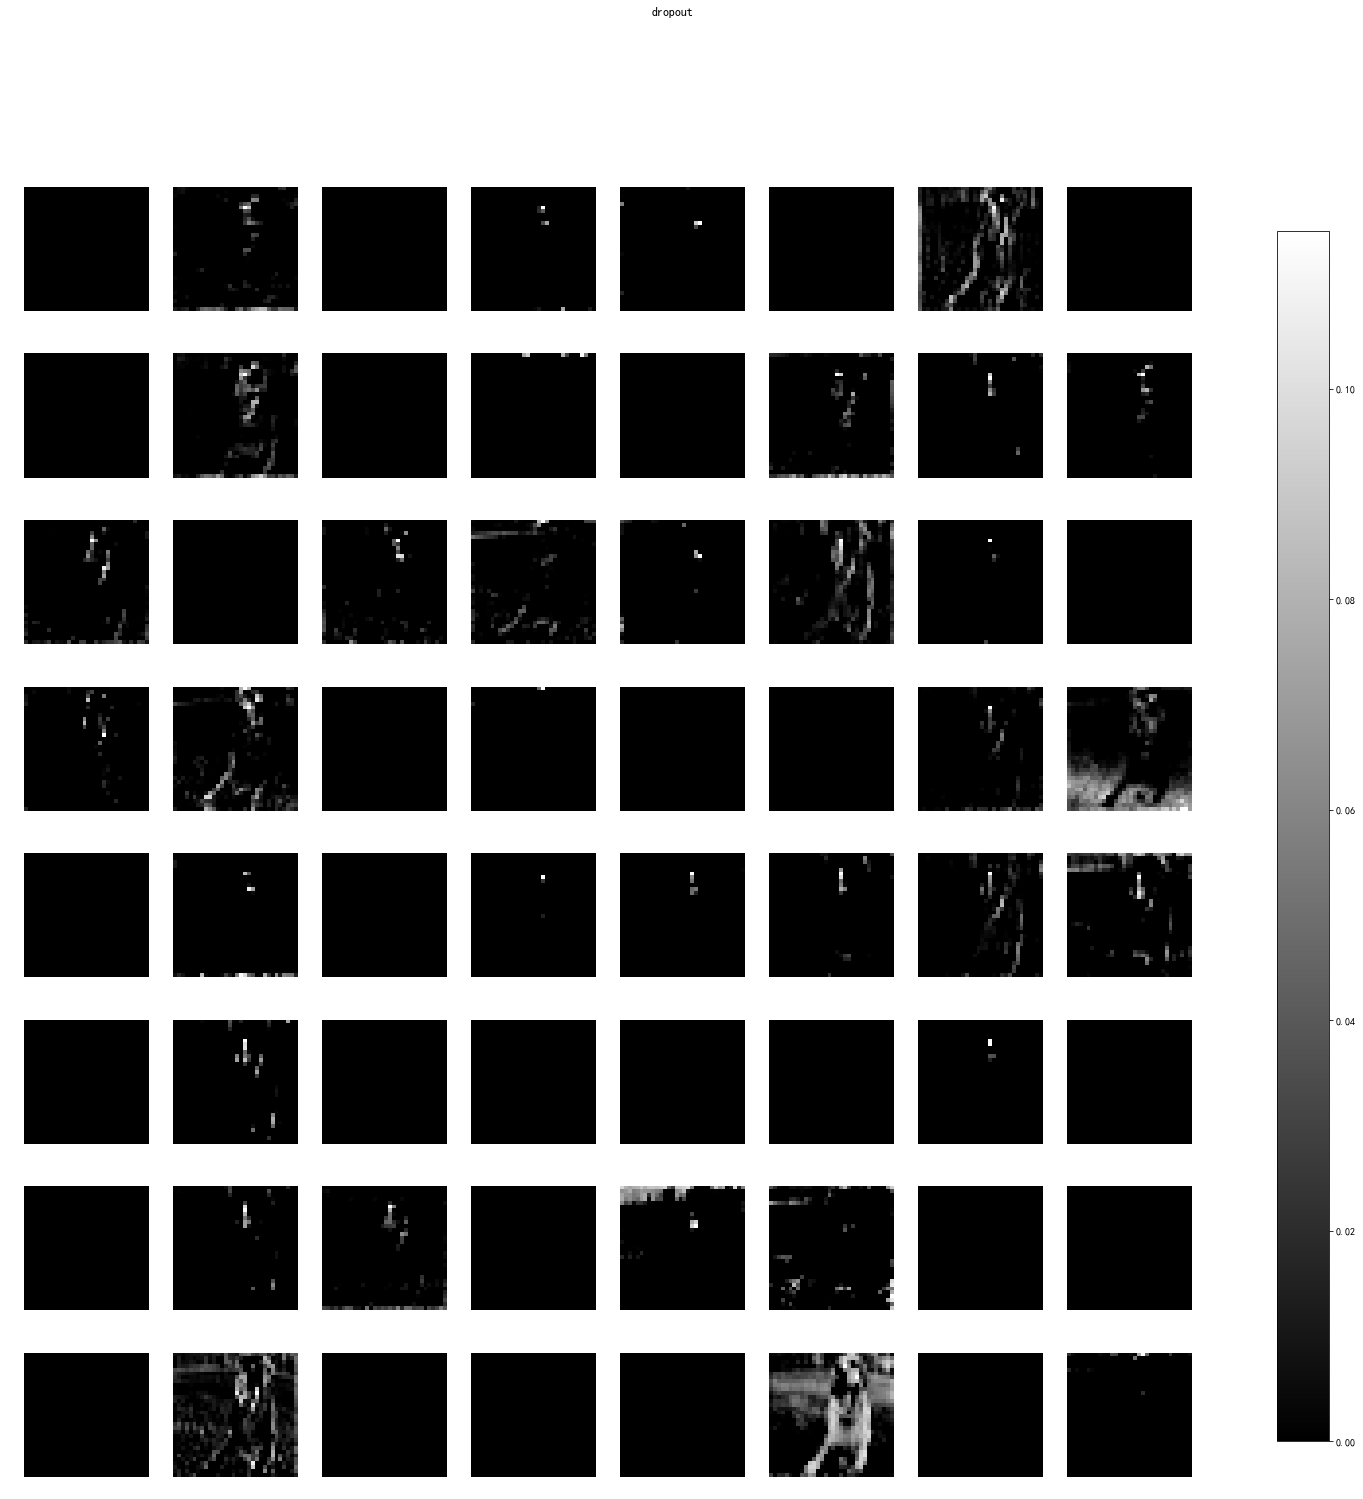

flatten (1, 65536) 


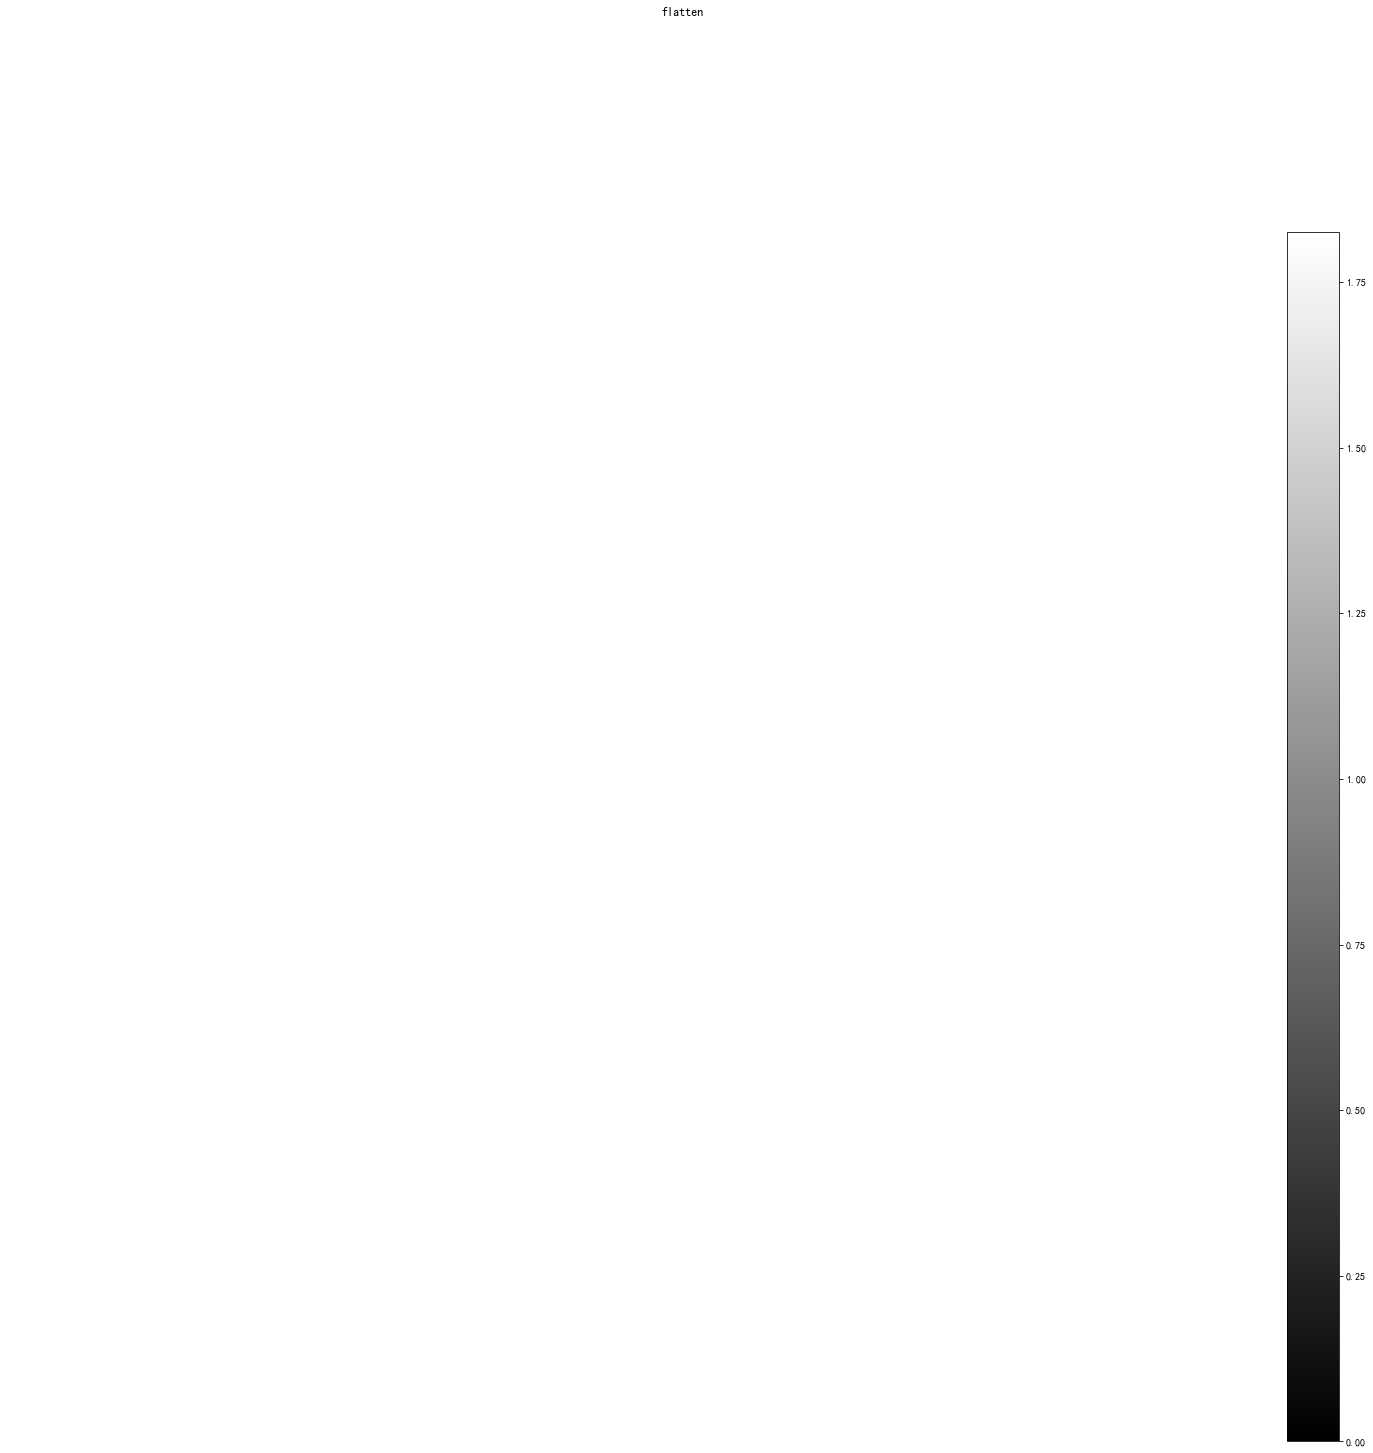

dense (1, 2048) 


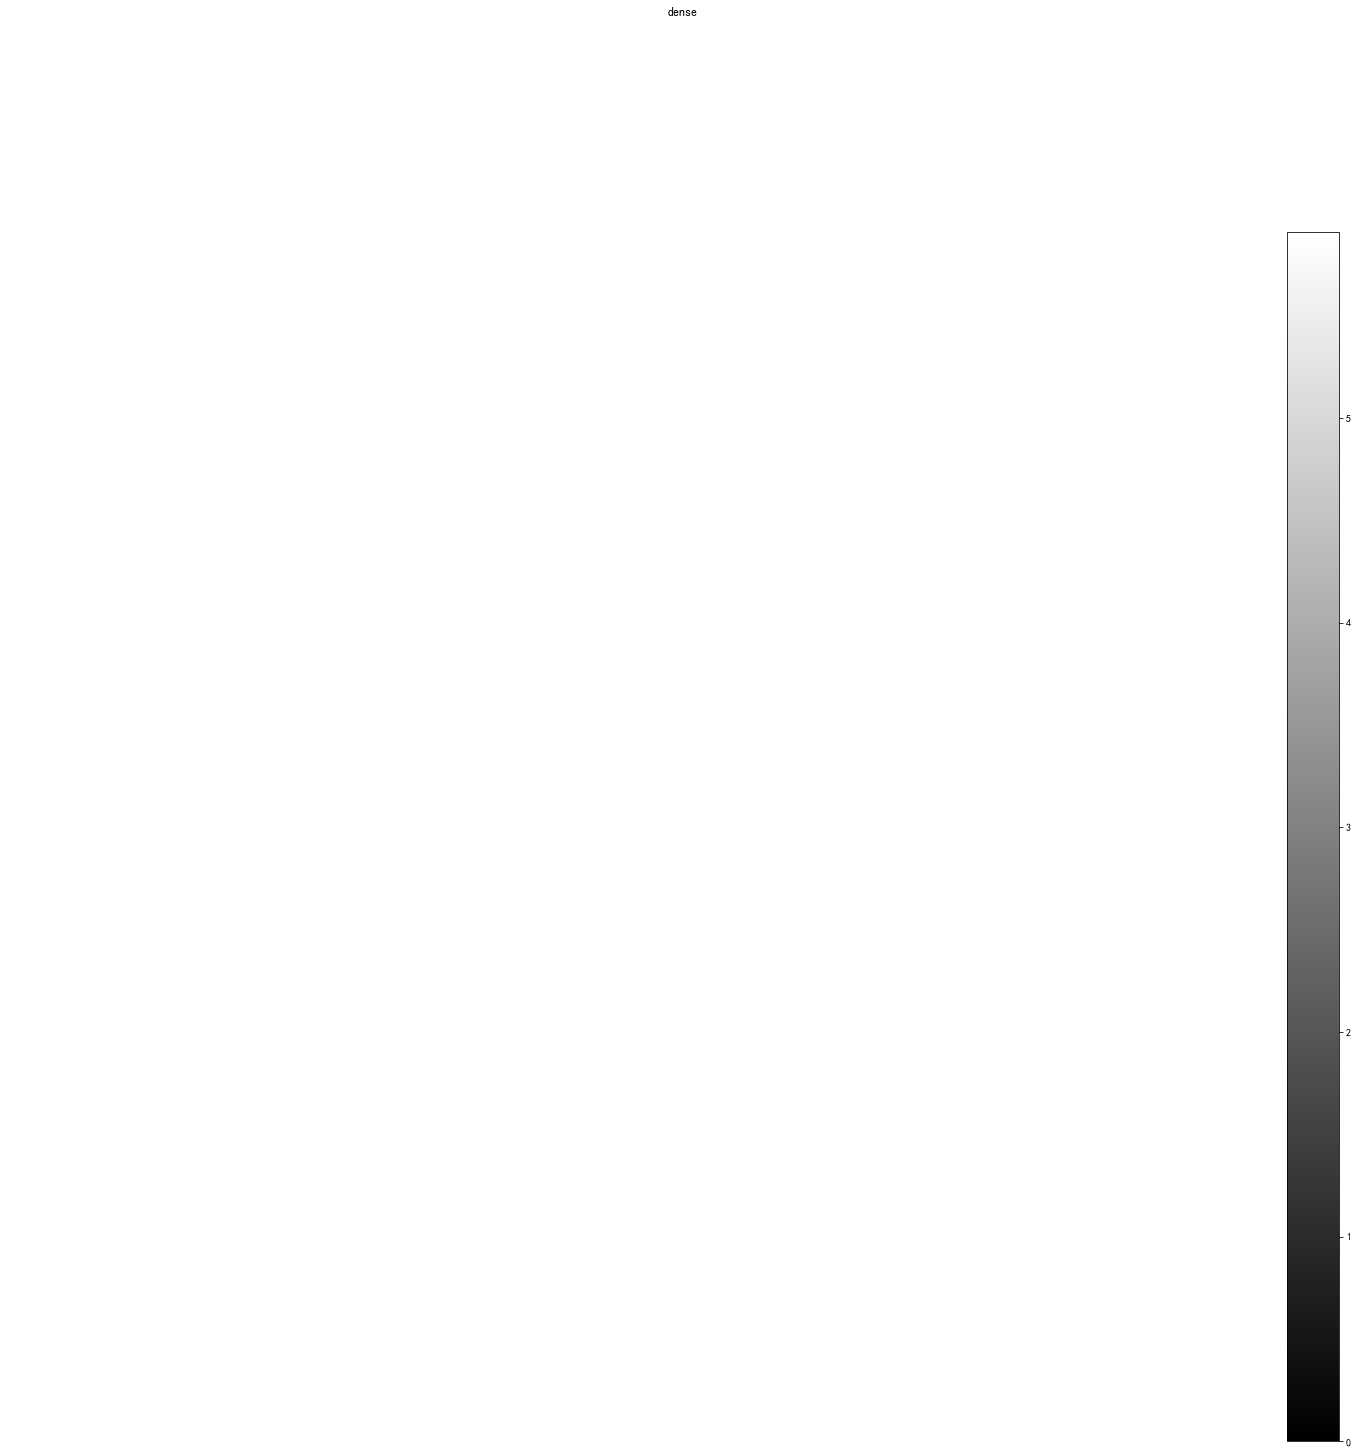

dense_1 (1, 12) 


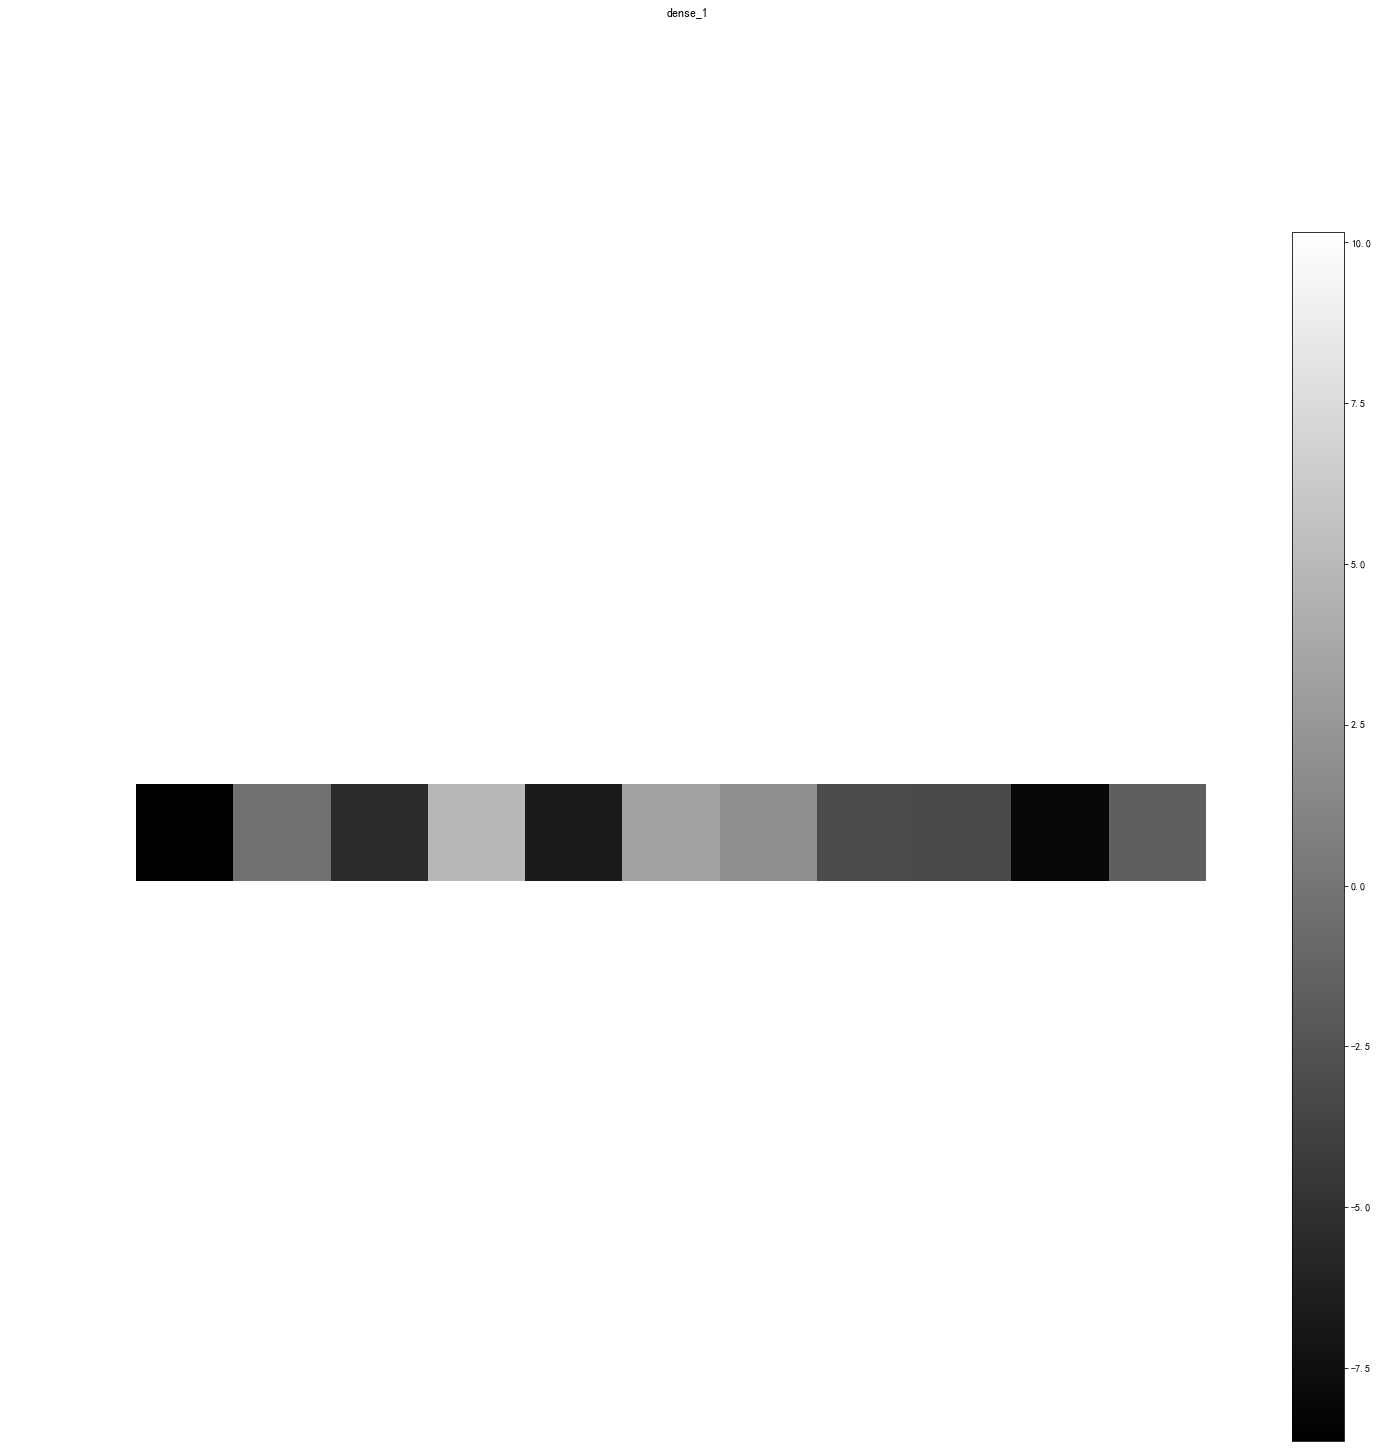

<Figure size 432x288 with 0 Axes>

In [37]:
from keract import get_activations, display_activations

for image_batch, labels_batch in train_ds:
    keract_inputs=image_batch[2:3]
    break
print(keract_inputs.shape)
activations = get_activations(model, keract_inputs)
display_activations(activations, cmap="gray", save=False)
plt.savefig('1.png')

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools 

In [88]:
Y_pred = model.predict_generator(val_ds, test_sample // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

d:\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [29]:
from keras.models import Model
feature_vectors_model = Model(model.input, model.get_layer('dense').output)
dtc_train_features = feature_vectors_model.predict(train_ds)  
print(dtc_train_features.shape)
dtc_test_features =  feature_vectors_model.predict(val_ds)
print(dtc_test_features.shape)

(4800, 2048)
(1200, 2048)


In [30]:
from sklearn.tree import DecisionTreeClassifier
dtc_cnn = DecisionTreeClassifier(criterion = 'gini')
dtc_cnn.fit(dtc_train_features, train_labels)

DecisionTreeClassifier()

In [32]:
y_pred_cnn = dtc_cnn.predict(dtc_test_features)
print(confusion_matrix(test_labels, y_pred_cnn))
print(classification_report(test_labels,y_pred_cnn))

[[ 7 14  6 10  5  4  7  4  8 15  6  9]
 [ 7  9  4  8  7  8  7  7  7  8 11  6]
 [ 7 10 10  6  5  9  5  7  3  8  4  9]
 [11 13 12  4 11 11  9  9 11 15  9  4]
 [10  7 10 11 12  4  8  8 10  5  8 10]
 [ 6  8  8 13 13  8 11  5  5 11  4  3]
 [ 7  6  9  8  9 10 14  6 10 17  5  7]
 [12  8  8 13 11  5  7 10  5  5 10  7]
 [11 12  6  8  7 10  9  8  7  9  7  6]
 [11  7  6 10  8  6  5  9  6  9 10  9]
 [ 7 13 12 10  5  5  4  9  5 13  9 11]
 [11 10  5 10  6  6 13 12  8 12  8  7]]
              precision    recall  f1-score   support

         0.0       0.07      0.07      0.07        95
         1.0       0.08      0.10      0.09        89
         2.0       0.10      0.12      0.11        83
         3.0       0.04      0.03      0.03       119
         4.0       0.12      0.12      0.12       103
         5.0       0.09      0.08      0.09        95
         6.0       0.14      0.13      0.14       108
         7.0       0.11      0.10      0.10       101
         8.0       0.08      0.07      0.08 

In [ ]:
print(confusion_matrix(test_labels, y_pred1))

In [24]:
train_labels.shape


(640,)

In [25]:
test.shape

(160, 2048)

In [26]:
train_ds

<PrefetchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [94]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    y_train=labels_batch
    break
y_train

(150, 256, 256, 3)
(150,)


<tf.Tensor: shape=(150,), dtype=int32, numpy=
array([1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0])>

In [39]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion = 'gini')

# Train the decision tree on the extracted features
#dtc.fit(dtc_features, train_labels) # y should be one-dimensional for sklearn
dtc.fit(test, test_labels)

DecisionTreeClassifier()

In [44]:
y_pred1 = dtc.predict(test)
print(confusion_matrix(test_labels, y_pred1))
print(classification_report(test_labels,y_pred1))

In [41]:
y_pred1.shape

(160,)

In [42]:
test_labels.shape

(160,)

In [43]:
print(confusion_matrix(test_labels, y_pred1))

[[84  0]
 [ 0 76]]


In [38]:
print(classification_report(test_labels,y_pred1))

              precision    recall  f1-score   support

         0.0       0.53      0.49      0.51        84
         1.0       0.48      0.53      0.50        76

    accuracy                           0.51       160
   macro avg       0.51      0.51      0.51       160
weighted avg       0.51      0.51      0.51       160



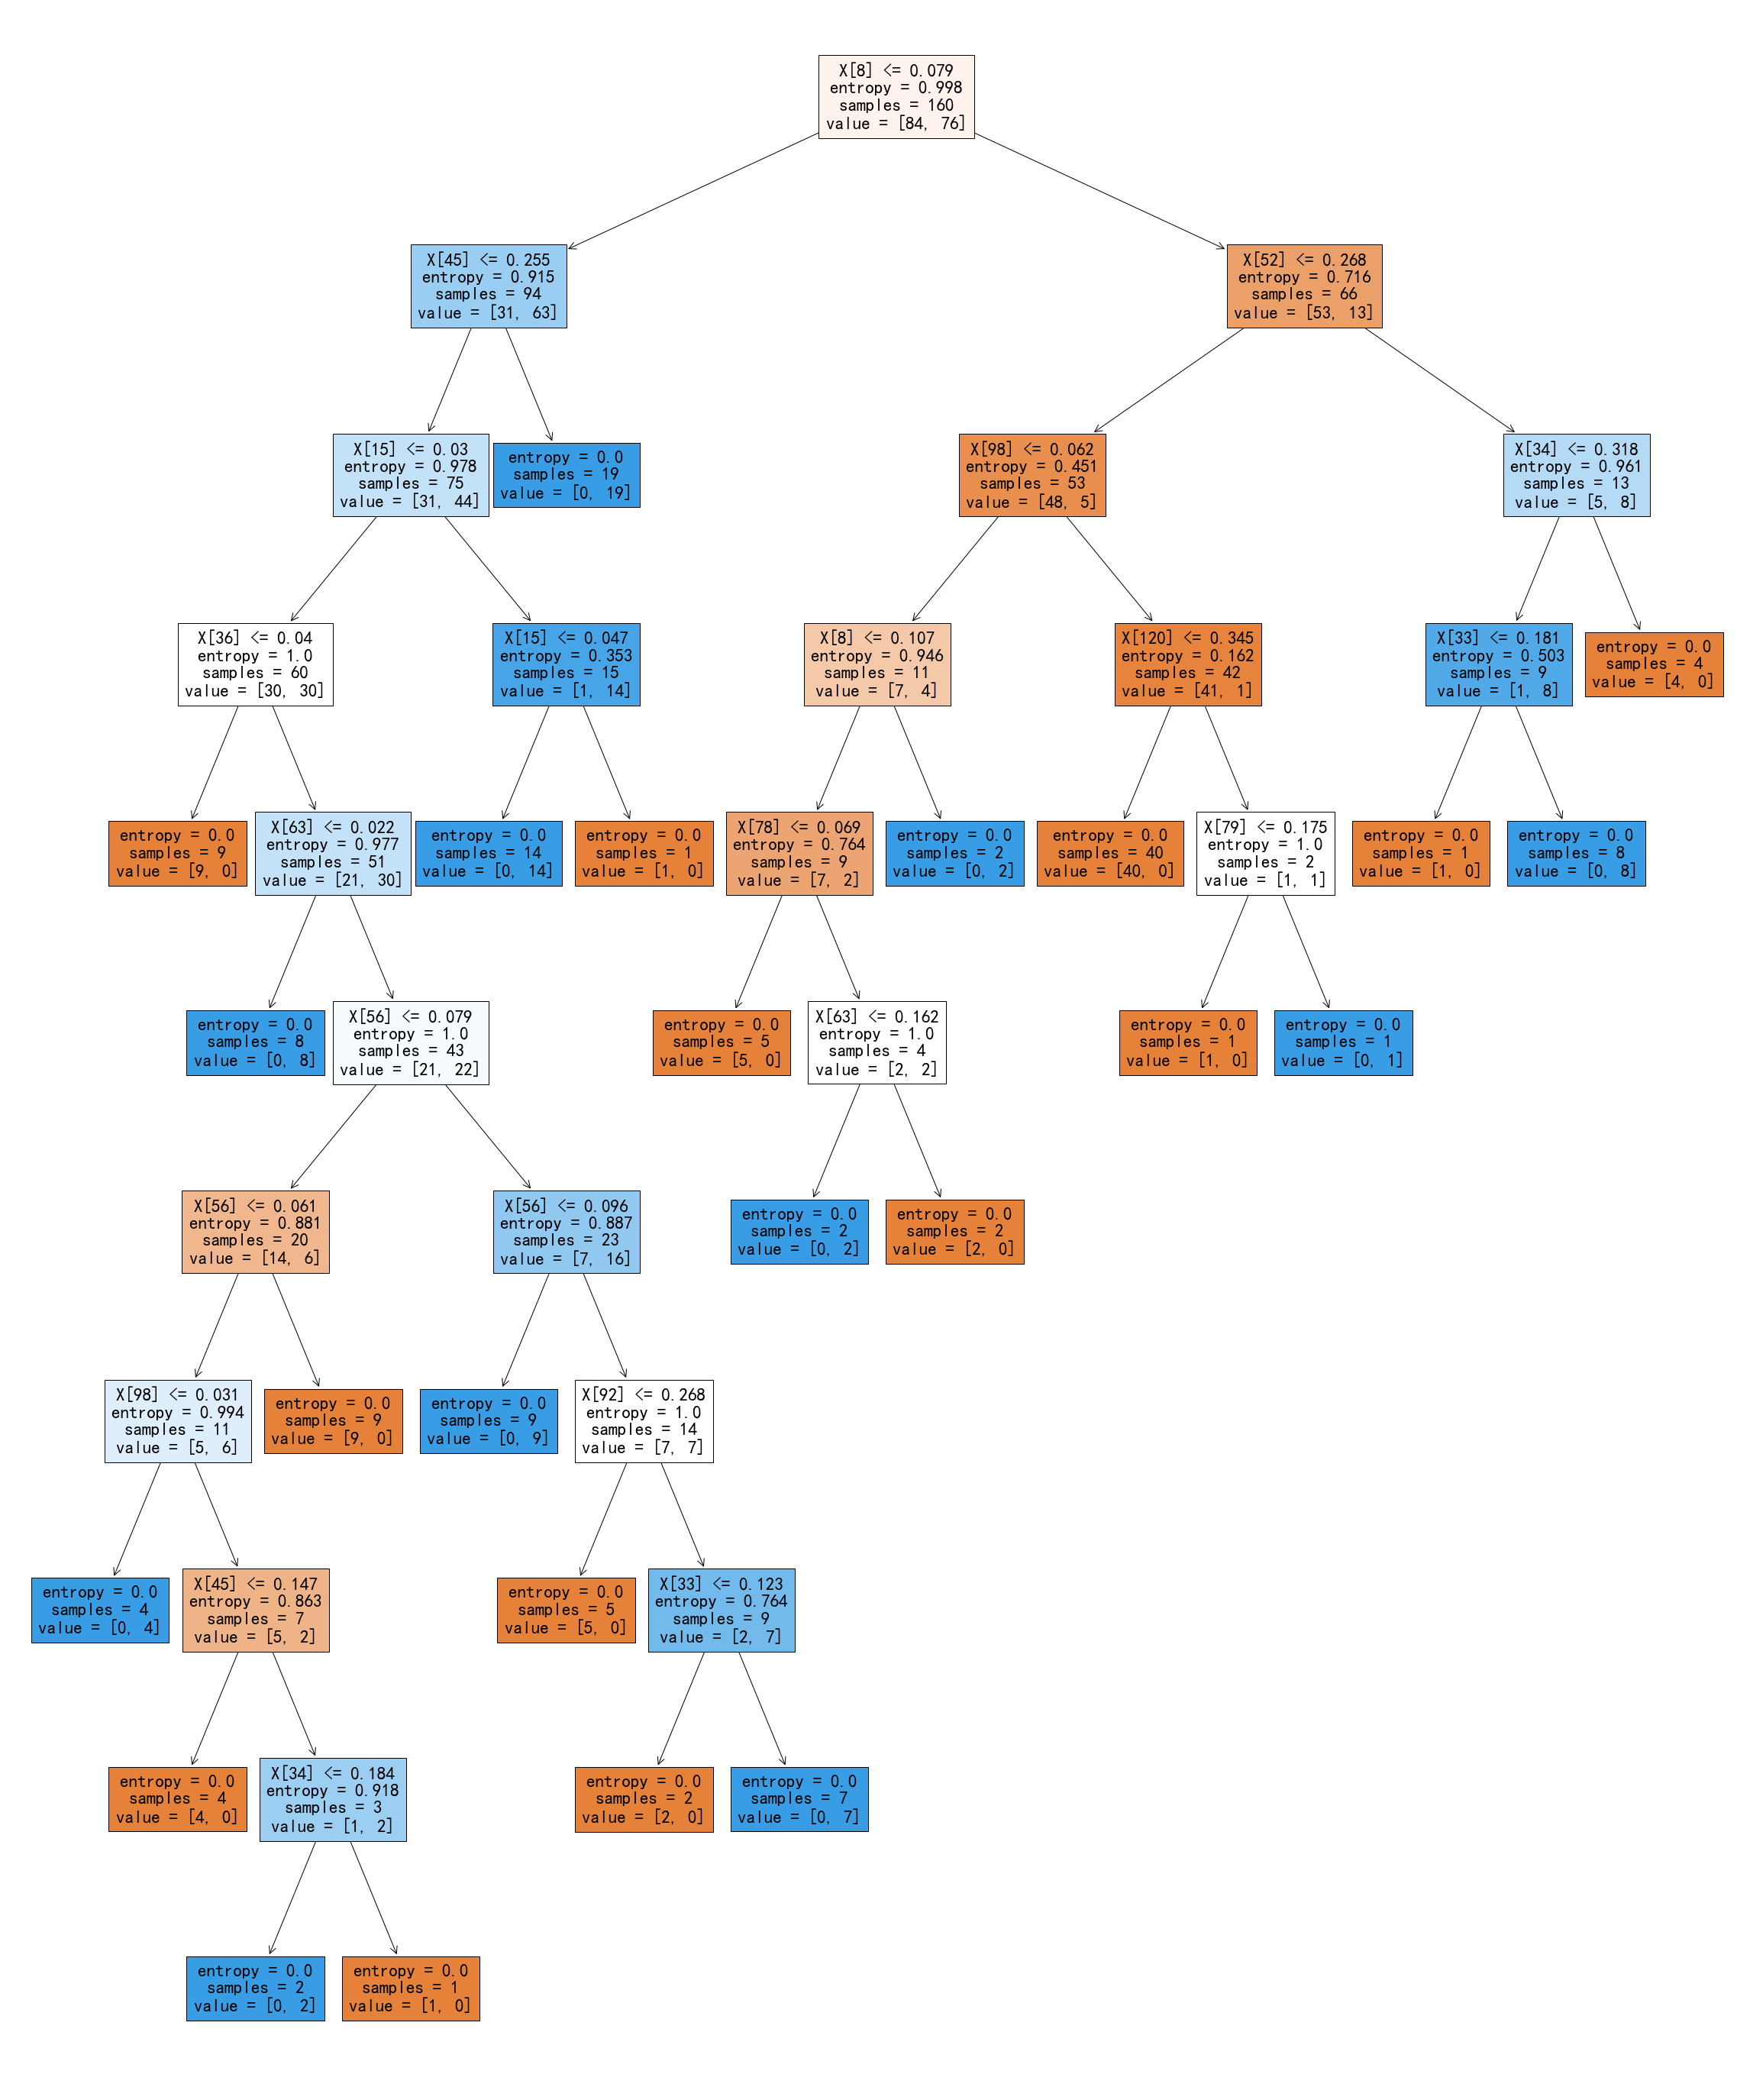

In [46]:
from sklearn.tree import plot_tree
plt.figure(figsize=(40,50))
plot_tree(dtc,filled=True)
plt.show()

In [48]:
model.save('./my_model.h5')

In [50]:
from keras.models import load_model
model1=load_model('./my_model.h5')

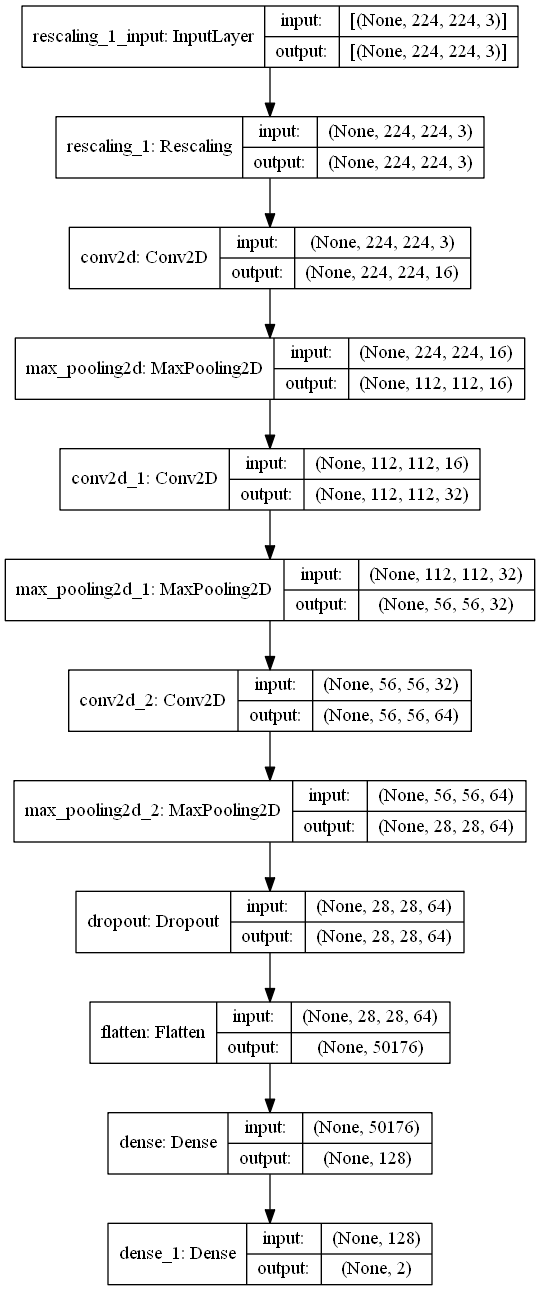

In [51]:
tf.keras.utils.plot_model(model1, show_shapes=True, show_layer_names= True, rankdir='TB')

In [53]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens,#这个地方设置混淆矩阵的颜色主题，这个主题看着就干净~
                          normalize=True):
   
 
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
 
    if cmap is None:
        cmap = plt.get_cmap('Blues')
 
    plt.figure(figsize=(15, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
 
    if target_names is not None:
        tick_marks = np.arange(len(target_names)+1)
        plt.xticks(tick_marks-0.5, target_names, rotation=45)
        plt.yticks(tick_marks-0.5, target_names)
 
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
 
 
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
 
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    #这里这个savefig是保存图片，如果想把图存在什么地方就改一下下面的路径，然后dpi设一下分辨率即可。
	#plt.savefig('/content/drive/My Drive/Colab Notebooks/confusionmatrix32.png',dpi=350)
    plt.show()
# 显示混淆矩阵
def plot_confuse(model, x_val, y_val):
    predictions = model.predict_classes(x_val)
    truelabel = y_val.argmax(axis=-1)   # 将one-hot转化为label
    conf_mat = confusion_matrix(y_true=truelabel, y_pred=predictions)
    plt.figure()
    plot_confusion_matrix(conf_mat, normalize=False,target_names=labels,title='Confusion Matrix')
#=========================================================================================
#最后调用这个函数即可。 test_x是测试数据，test_y是测试标签（这里用的是One——hot向量）
#labels是一个列表，存储了你的各个类别的名字，最后会显示在横纵轴上。
#比如这里我的labels列表
labels = ['1','2']


In [56]:
plot_confuse(model, train_ds, val_ds)

d:\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


AttributeError: 'PrefetchDataset' object has no attribute 'argmax'